# Extract the MS2 scan and do signature neutral loss search
- run multiple files
- need to define a precursor target list & scan range (let's just try to do more inclusive one)

In [1]:
# !pip install pymzml
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pymzml
import os
import pandas as pd
import sys

In [3]:
sys.path.append('../pyutils/')  # add the second parent directory
from searchMS2 import *

In [4]:
# spectrum.selected_precursors
# [{'mz': 417.320373535156, 'charge': 1, 'precursor id': '2'}]

In [5]:
exp_label = 'stemCell_pooledDDA' # 
output_fdr = 'output_stemCell_pooledDDA_in-silico' # 
dir_path = "../../../../MS_MS_raw_mzML/WT_Klof2_C1_RPneg/mzML/" # 
annot_dict_input = "./data/input/chainable_annotation_CD8TD_sample_AX.json" # 
files_and_dirs = os.listdir(dir_path)

mz_ppm = 100 # select precursor ppm range
rt_delta = 30 # select retention time delta -30, 30?

# Get the full path for each file/directory in the list
infiles = [os.path.join(dir_path, file) for file in files_and_dirs]

In [6]:
try:
    os.mkdir(f"./data/{output_fdr}")
except:
    None

In [7]:
exps = []
for infile in infiles:
    exps.append(pymzml.run.Reader(infile))

[Warning] Not index found and build_index_from_scratch is False


## Basic information - using the first instance

In [8]:
exp = pymzml.run.Reader(infiles[0])

[Warning] Not index found and build_index_from_scratch is False


In [9]:
# How many spectra
exp.get_spectrum_count()

7267

In [10]:
exp.ms_precisions # ms-level 1: ppm 5; ms-level 2: ppm 20?

{None: 0.0001, 0: 0.0001, 1: 5e-06, 2: 2e-05, 3: 2e-05}

##### summary
- a probably 12 min run (720 secs) for 7267 scans
- 0.17964 second/scan

## Load target list

In [13]:
import json

In [14]:
with open(annot_dict_input) as f: # 
    annot_dict = json.load(f)

In [15]:
FTIDs = list(annot_dict.keys())

In [16]:
df_feat_annot = pd.read_csv("../../../../asari-output-RPneg/output_asari_project_31312361/Feature_annotation.tsv",
                           sep = '\t', index_col=0)

In [17]:
df_feat_annot.head()

mz       rtime  apex(scan number) [EmpCpd]interim_id  \
[peak]id_number                                                                 
F22              505.150330  140.614329                626       kp1_506.1566   
F144             506.151741  140.614329                626       kp1_506.1566   
F190             401.305092  149.563090                666       kp2_401.3091   
F24              400.301849  149.563090                666       kp2_401.3091   
F193             401.309975  189.834108                850       kp3_401.3133   

                [EmpCpd]ion_relation neutral_formula  \
[peak]id_number                                        
F22                          M0,M-H-            None   
F144                    13C/12C,M-H-            None   
F190                    13C/12C,M-H-            None   
F24                          M0,M-H-            None   
F193                    13C/12C,M-H-            None   

                 neutral_formula_mass          \
[peak]id_number                                 
F22                                506.156634   
F144                               506.156634   
F190                               401.309070   
F24                                401.309070   
F193                               401.313346   

                                                    name_1st_guess  \
[peak]id_number                                                      
F22              8-(2-{[(2E)-3-(3,4-dihydroxyphenyl)prop-2-enoy...   
F144             8-(2-{[(2E)-3-(3,4-dihydroxyphenyl)prop-2-enoy...   
F190                                                           NaN   
F24                                                            NaN   
F193                              3-hydroxypentadecanoyl carnitine   

                                                 matched_DB_shorts  \
[peak]id_number                                                      
F22              (HMDB0128938$8-(2-{[(2E)-3-(3,4-dihydroxypheny...   
F144             (HMDB0128938$8-(2-{[(2E)-3-(3,4-dihydroxypheny...   
F190                                                           NaN   
F24                                                            NaN   
F193                (HMDB0061641$3-hydroxypentadecanoyl carnitine)   

                              matched_DB_records  
[peak]id_number                                   
F22               ('C28H26O9_506.157682', '', 1)  
F144              ('C28H26O9_506.157682', '', 1)  
F190                                         NaN  
F24                                          NaN  
F193             ('C22H43NO5_401.314123', '', 1)

In [18]:
## missing the rtime range parameters
df_feat = pd.read_csv("../../../../asari-output-RPneg/output_asari_project_31312361/export/full_Feature_table.tsv",
                      sep = '\t', index_col=0)

In [19]:
df_feat.columns

Index(['mz', 'rtime', 'rtime_left_base', 'rtime_right_base',
       'parent_masstrack_id', 'peak_area', 'cSelectivity', 'goodness_fitting',
       'snr', 'detection_counts', 'MT_20230308_032', 'Blank_20230308_002',
       'Blank_20230308_004', 'Blank_20230308_006', 'Blank_std_20230308_1_002',
       'MT_20230308_002', 'MT_20230308_004', 'MT_20230308_006',
       'MT_20230308_008', 'MT_20230308_010', 'MT_20230308_012',
       'MT_20230308_014', 'MT_20230308_016', 'MT_20230308_018',
       'MT_20230308_020', 'MT_20230308_022', 'MT_20230308_024',
       'MT_20230308_026', 'MT_20230308_028', 'MT_20230308_030'],
      dtype='object')

In [20]:
# Select the desired rows and columns from the DataFrame
subset = df_feat_annot.loc[FTIDs, ['mz', 'rtime', 'apex(scan number)']]
# drop duplicates
subset_dd = subset.drop_duplicates() 
# Convert the subset to a dictionary with row-wise orientation
target_dict = subset_dd.to_dict(orient='index')

In [21]:
if 'rtime_left_base' not in list(annot_dict.values())[0]:
    for ftID, v in annot_dict.items():
        row = df_feat.loc[ftID] # get the row
        annot_dict[ftID]['mz'] = row['mz']
        annot_dict[ftID]['rtime'] = row['rtime']
        annot_dict[ftID]['rtime_left_base'] = row['rtime_left_base']
        annot_dict[ftID]['rtime_right_base'] = row['rtime_right_base']
        annot_dict[ftID]['cSelectivity'] = row['cSelectivity']
        annot_dict[ftID]['goodness_fitting'] = row['goodness_fitting']
        annot_dict[ftID]['snr'] = row['snr']

In [22]:
list(annot_dict.items())[0]

('F4086',
 {'name': 'PS 11:6',
  'neutral_mass': 429.08248284315,
  'formula': 'C17H20NO10P',
  'formula_dict': {'C': 17, 'H': 20, 'O': 10, 'N': 1, 'P': 1},
  'isomers': [],
  '[M-H+e]': 428.07520639082907,
  'annotation_evidence': {'in-silico': '1'},
  'mz': 428.0752,
  'rtime': 20.78,
  'rtime_left_base': 19.92,
  'rtime_right_base': 23.29,
  'cSelectivity': 1.0,
  'goodness_fitting': 0.92,
  'snr': 332.0})

## Do a pre-filtering, mostly those that fall outside rtime 200-400 seconds, probably won't be PS

In [23]:
target_dict_upd = {}
for k,v in target_dict.items():
    if 100<v['rtime']<500:
        target_dict_upd.update({k:v})

In [24]:
len(target_dict)

1144

In [25]:
len(target_dict_upd)

947

In [26]:
# testing
target_dict_test = {k:v for k,v in target_dict_upd.items() if k == "F13804"}
target_dict_test

{'F13804': {'mz': 836.5431061,
  'rtime': 308.9440999,
  'apex(scan number)': 1411}}

## get potential precursor from multiple files

In [27]:
def get_delta_mz(mz, ppm=20):
    '''
    get delta mz based on ppm
    '''
    delta_mz = round((mz * ppm * 1e-6),4)
    return(delta_mz)

# limit to a retention time window for the spectra

In [28]:
def subset_specs(exp,
                 rt_range):
    rt_scans = [round(spec.scan_time[0]*60,2) for spec in exp]
    ID_lower = next((i for i, x in enumerate(rt_scans) if x >= rt_range[0] ), None)
    ID_upper = next((i for i, x in enumerate(rt_scans) if x >= rt_range[1] ), None)
    sub_exp = []
    for spec in exp:
        if ID_lower < spec.ID < ID_upper:
            sub_exp.append(spec)
    return(sub_exp)

In [29]:
sub_exps = []
for exp in exps: 
    sub_exps.append(subset_specs(exp,rt_range = [200,500]))

[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False


In [30]:
res_dict = {}
ii = 0
for exp in sub_exps:
    for k,v in target_dict_upd.items(): # target_dict_test target_dict_upd
        delta_mz = get_delta_mz(v['mz'],mz_ppm)
        spectra = get_potential_precursor_from_exp_filtbyRt(exp, 
                              min_rt_sec = v['rtime'] - rt_delta, 
                              max_rt_sec = v['rtime'] + rt_delta, 
                              min_mz = v['mz'] - delta_mz,
                              max_mz = v['mz'] + delta_mz, 
                              ms_level=2)
        res_dict[k] = spectra

In [31]:
res_dict_clean = {k:v for k,v in res_dict.items() if len(v) != 0}

In [32]:
parsed_res_dict_clean = {}
for k,v in res_dict_clean.items():
    parsed_res_dict_clean[k] = []
    for spec_obj in v:
        parsed_res_dict_clean[k].append(export_spectrum(spec_obj))

In [33]:
def search_NL_customSpecObj(spectra,
              NL_mz = 87.03124,
              ppm_prec = 100,
              ppm = 40):
    res_data = []

    for spec in spectra:
        in_ms2_precursor = find_in_ms2_precursor(spec,ppm_prec = 100, present = 0.05)
        if np.isnan(in_ms2_precursor):
            sel_prec_mz = spec['precursor_mz'] # this m/z will not be exactly the precursor m/z    
        else:
            sel_prec_mz = in_ms2_precursor
        
        sel_mz = [mz for mz in spec['mzs'] if abs(mz - sel_prec_mz) < (np.ceil(NL_mz)+1)] # +1 is to increase a little bit the range
    
        for mz in sel_mz:
            calc_ppm = cal_ppm((sel_prec_mz - mz),NL_mz)
            if calc_ppm < ppm:
                print(calc_ppm)
                res_data.append(spec)
                break
    return res_data

In [34]:
parsed_NL_res_dict = {}
for FTID, spectra in parsed_res_dict_clean.items():
    parsed_NL_res_dict.update({FTID: search_NL_customSpecObj(spectra)})

2.886894407660695
13.053637047446093
0.6234291557762887
4.356822762550788
6.43290020009984
4.356822762550788
6.43290020009984
6.383528560942258
7.885099648961544
8.530970459108186
0.06799821198779823
12.794211523617127
6.383528560942258
7.885099648961544
8.530970459108186
0.06799821198779823
12.794211523617127
3.3969932094708484
0.6393627301604388
0.48967689602942216
0.8305656247296543
3.3969932094708484
0.6393627301604388
0.48967689602942216
0.8305656247296543
3.3969932094708484
0.6393627301604388
14.643403836288526
4.3271997793174934
0.5778725981588445
2.944345042483044
4.064632424131402
6.9798033149859355
2.8633306701962686
6.440979195764607
1.5379265681841676
1.5060594194158674
1.5379265681841676
1.5060594194158674
1.5379265681841676
1.5060594194158674
0.617594325646528
12.021545366620883
3.446589265573814
0.617594325646528
12.021545366620883
0.617594325646528
12.021545366620883
3.446589265573814
9.208484002384022
9.287703041720283
35.89722135970324
2.886894407660695
13.05363704744

In [35]:
parsed_NL_res_dict_clean = {k:v for k,v in parsed_NL_res_dict.items() if len(v) != 0}

In [36]:
with open(f"./data/{output_fdr}/NL_matched_specs.json", "w") as f:
    json.dump(parsed_NL_res_dict_clean, f, indent=2)

## Document annotation in the annotation dict

In [37]:
for k,v in parsed_NL_res_dict_clean.items():
    if "MS2" not in annot_dict[k]['annotation_evidence']:
        annot_dict[k]['annotation_evidence']["MS2"] = []
        
    in_ms2_precursors = [find_in_ms2_precursor(x) for x in v]
    record = {
        'source':exp_label,
        'estimated_time': [x['est_time'] for x in v],
        'precursor': [x['precursor_mz'] for x in v],
        'in-ms2-precursor': in_ms2_precursors,
        'ppm_btw_precur_feat_mz': round(cal_ppm(np.mean([x['precursor_mz'] for x in v]),annot_dict[k]['mz']),2),
        'ppm_btw_in-ms2_precur_feat_mz': round(cal_ppm(np.nanmean(in_ms2_precursors,),annot_dict[k]['mz']),2),
        'parameters':{
            'neutral_loss': 87.03124,
            'ppm_NL':40,
            'rt_window':[-rt_delta,rt_delta],
            'mz_ppm':mz_ppm            }
        }
    if not np.isnan(record['ppm_btw_in-ms2_precur_feat_mz']):
        if record['ppm_btw_in-ms2_precur_feat_mz'] > 20: 
            record = {}
            print(f"exlude {k}/{annot_dict[k]['name']} because out of ppm range to in-ms2 precursor m/z")
    else:
        if record['ppm_btw_precur_feat_mz'] > 20:
            record = {}
            print(f"exlude {k}/{annot_dict[k]['name']} because out of ppm range comparing to precursor m/z")
        
    if record not in annot_dict[k]['annotation_evidence']['MS2']:
        annot_dict[k]['annotation_evidence']['MS2'].append(record)

exlude F9865/LPS 35:2 because out of ppm range to in-ms2 precursor m/z
exlude F9864/LPS 35:2 because out of ppm range to in-ms2 precursor m/z
exlude F9866/LPS 35:2 because out of ppm range to in-ms2 precursor m/z
exlude F12087/LPS 36:1 because out of ppm range to in-ms2 precursor m/z
exlude F13366/LPS 37:1 because out of ppm range to in-ms2 precursor m/z
exlude F13364/LPS 37:1 because out of ppm range to in-ms2 precursor m/z
exlude F13365/LPS 37:1 because out of ppm range to in-ms2 precursor m/z
exlude F13368/LPS 37:1 because out of ppm range to in-ms2 precursor m/z
exlude F13367/LPS 37:1 because out of ppm range to in-ms2 precursor m/z
exlude F13184/LPS 37:2 because out of ppm range to in-ms2 precursor m/z
exlude F12926/LPS 37:3 because out of ppm range to in-ms2 precursor m/z
exlude F12749/LPS 37:4 because out of ppm range to in-ms2 precursor m/z
exlude F12748/LPS 37:4 because out of ppm range to in-ms2 precursor m/z
exlude F12746/LPS 37:4 because out of ppm range to in-ms2 precursor

In [42]:
MS2_annot_dict = {}
for k,v in annot_dict.items():
    if 'MS2' in v['annotation_evidence']:
        if len(v['annotation_evidence']['MS2']) > 0:
            MS2_annot_dict.update({k:v})

In [ ]:
def annot_dict2table()

In [52]:
df = pd.DataFrame(annot_dict).transpose()
df.loc[ [200 < x < 500 for x in df['rtime']],:].to_csv("./test.csv")

In [43]:
MS2_annot_dict['']

{'F13353': {'name': 'PS 36:1',
  'neutral_mass': 789.55198477695,
  'formula': 'C42H80NO10P',
  'formula_dict': {'C': 42, 'H': 80, 'O': 10, 'N': 1, 'P': 1},
  'isomers': [],
  '[M-H+e]': 788.544708324629,
  'hits_isotopologue_chain': {'F13353': {'0': ['F13353'], '1': ['F13431']},
   'F13352': {'0': ['F13352'], '1': ['F13430']}},
  'annotation_evidence': {'in-silico': '1',
   'isotopes': '1',
   'MS2': [{'source': 'stemCell_pooledDDA',
     'estimated_time': [342.69, 346.61, 351.15, 358.57, 363.39],
     'precursor': [788.5436, 788.5444, 788.5441, 788.544, 788.5439],
     'in-ms2-precursor': [788.54321, nan, 788.54205, 788.54346, 788.54419],
     'ppm_btw_precur_feat_mz': 0.63,
     'ppm_btw_in-ms2_precur_feat_mz': 1.61,
     'parameters': {'neutral_loss': 87.03124,
      'ppm_NL': 40,
      'rt_window': [-30, 30],
      'mz_ppm': 100}}]},
  'mz': 788.5445,
  'rtime': 343.82,
  'rtime_left_base': 341.34,
  'rtime_right_base': 346.3,
  'cSelectivity': 0.49,
  'goodness_fitting': 0.96,
  

In [38]:
with open(f"./data/{output_fdr}/chainable_annotation_{exp_label}.json", "w") as f:
    json.dump(annot_dict, f, indent=2)

# plot accordingly

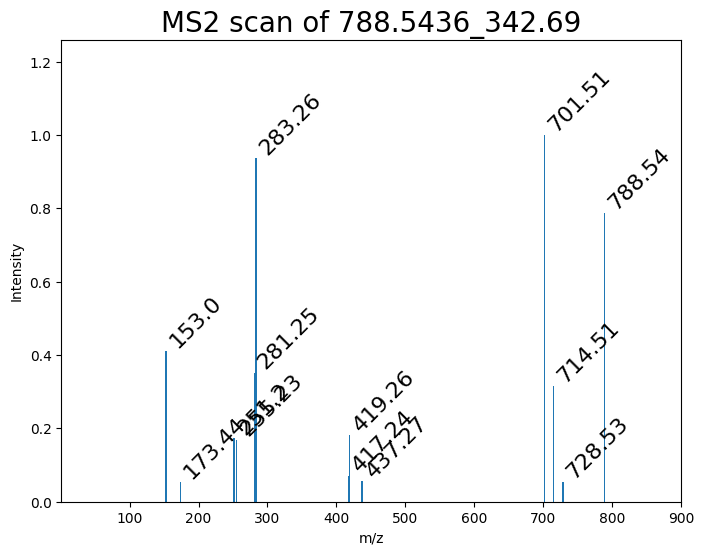

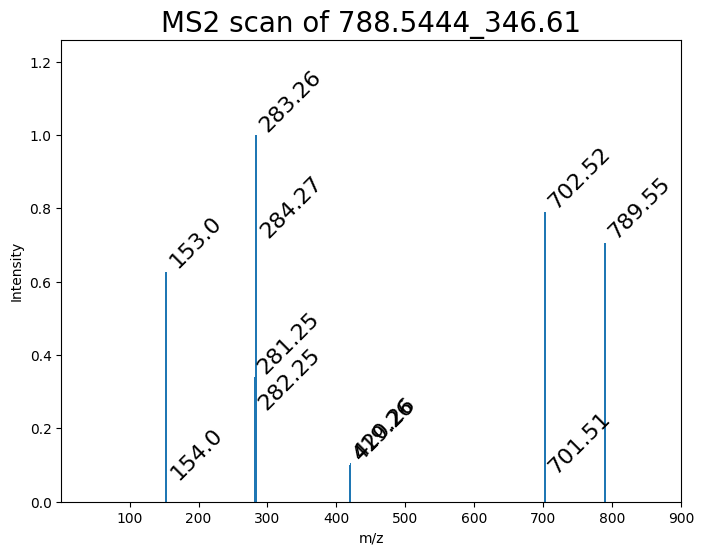

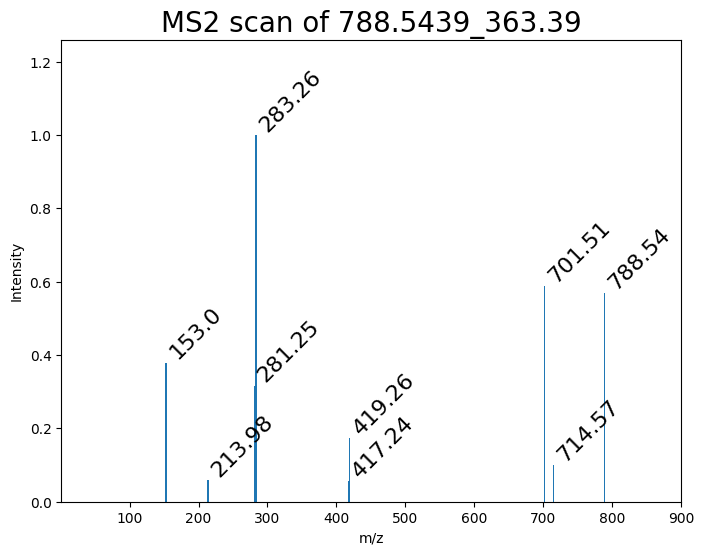

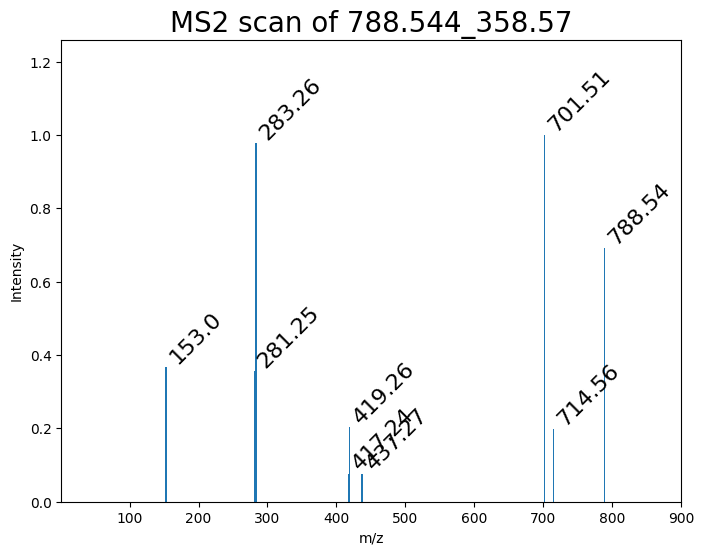

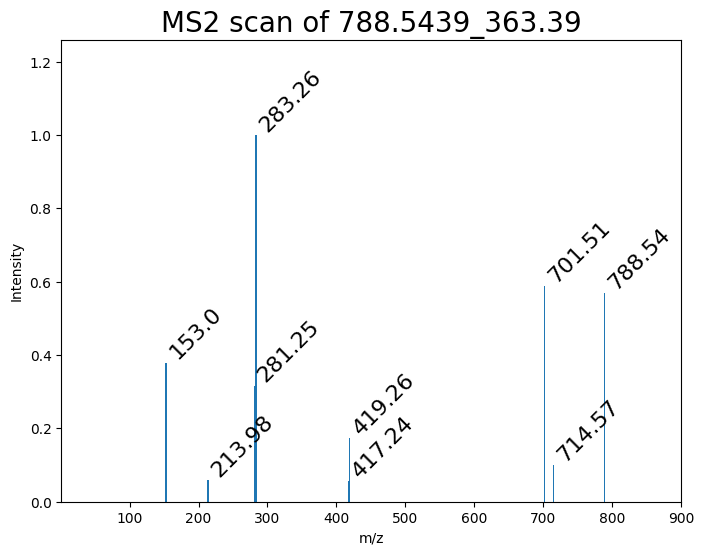

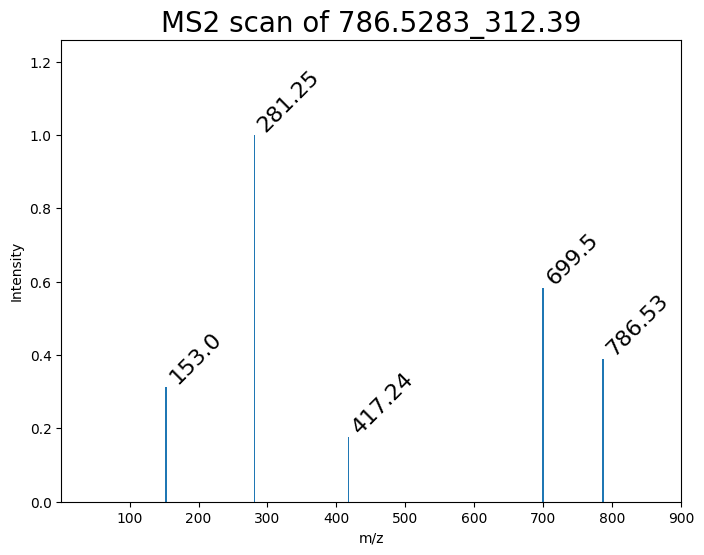

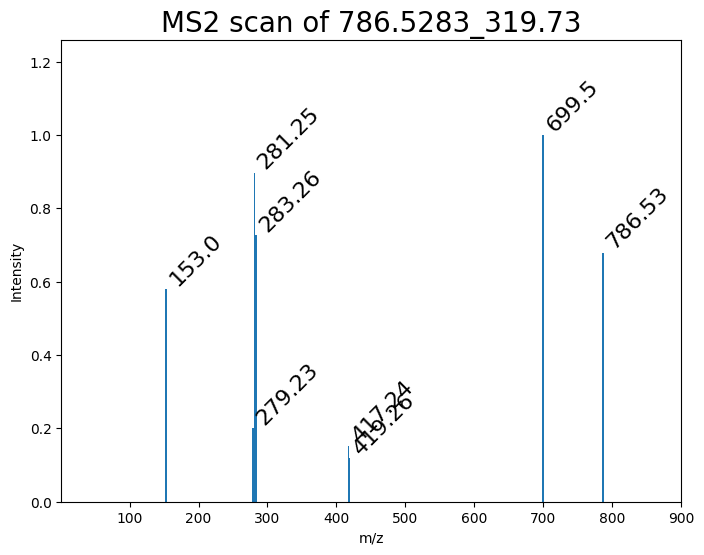

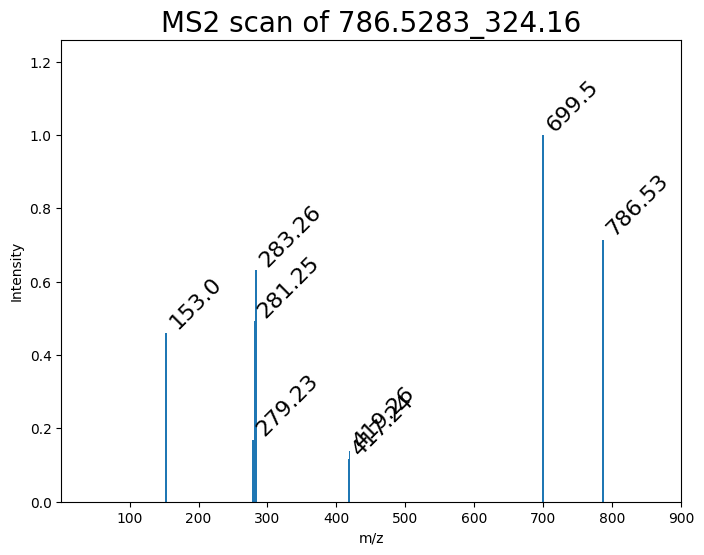

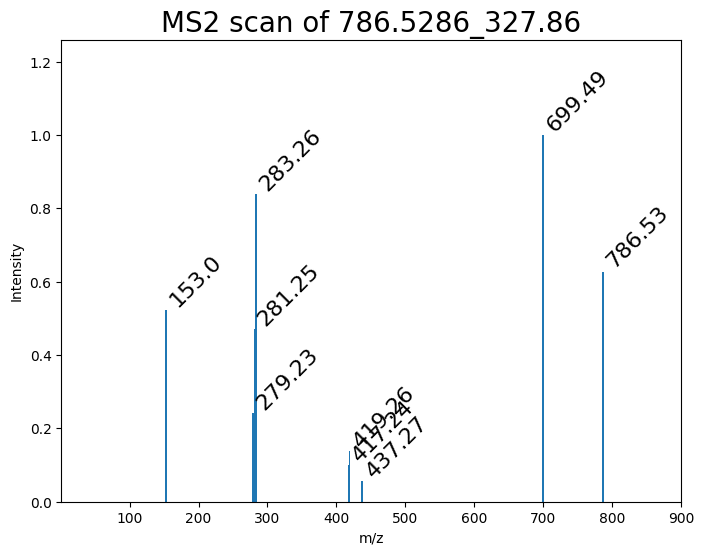

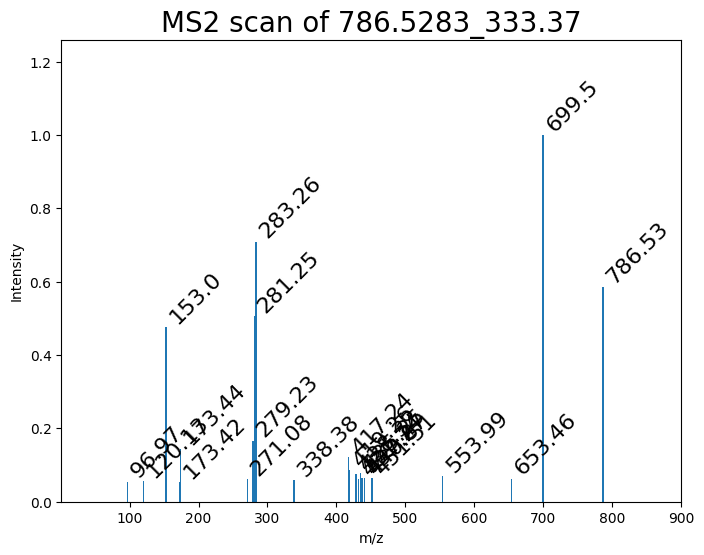

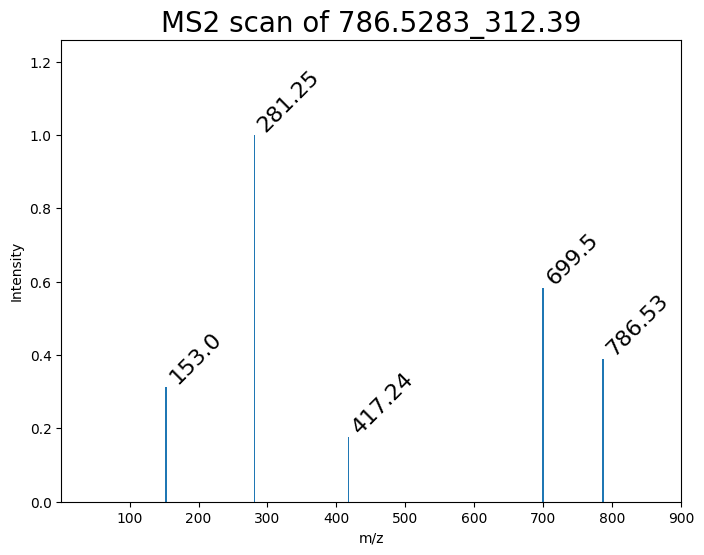

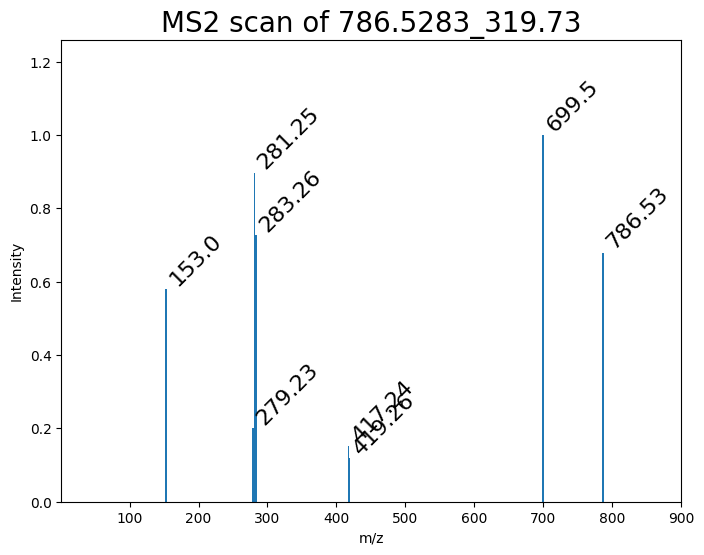

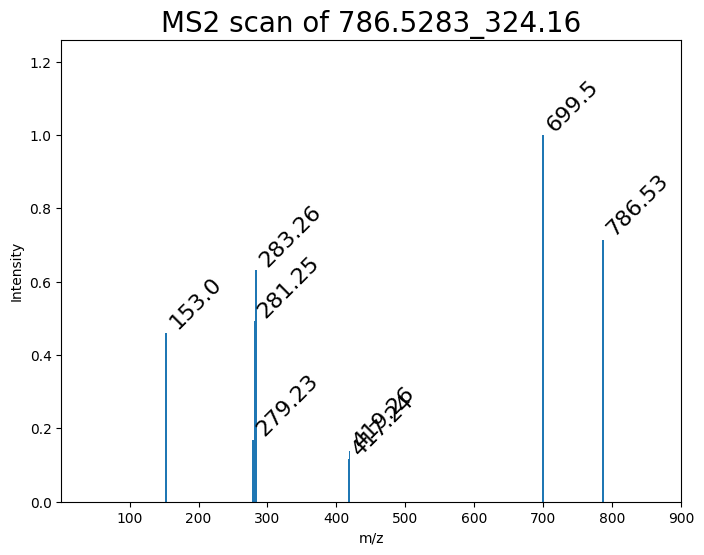

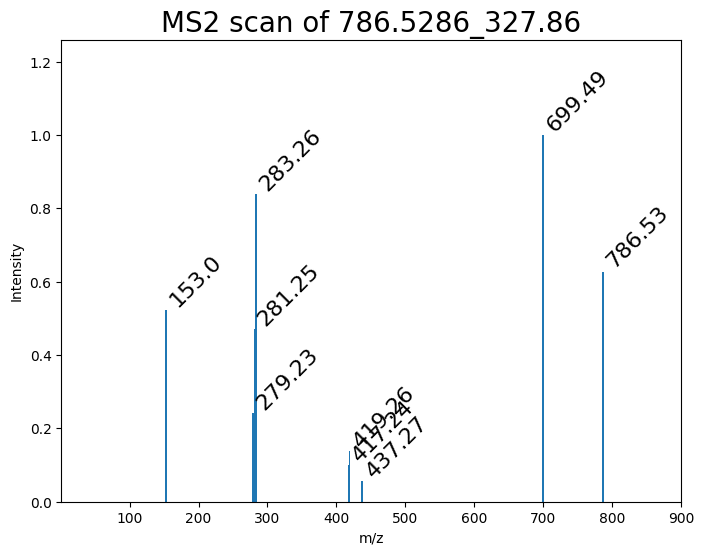

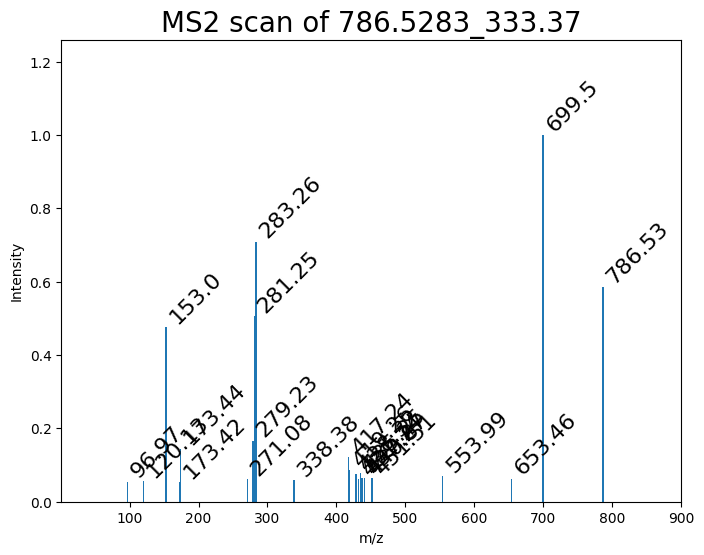

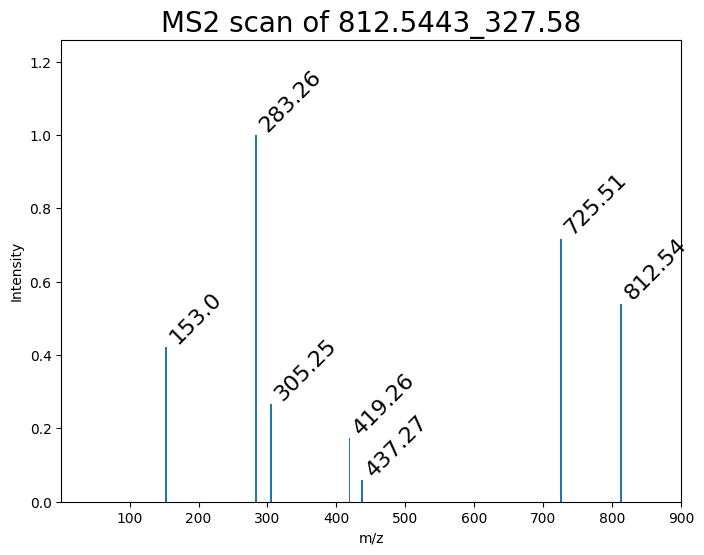

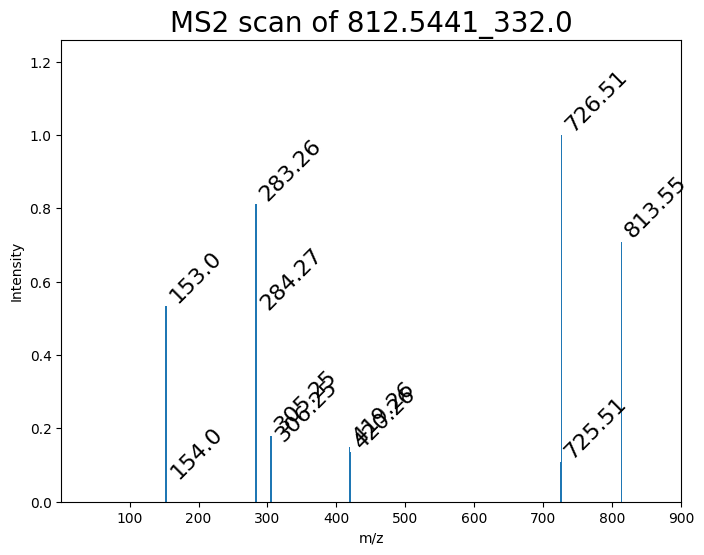

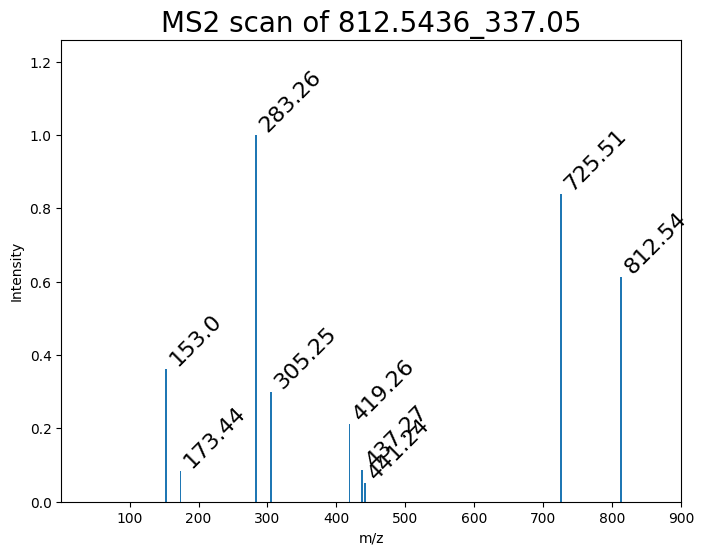

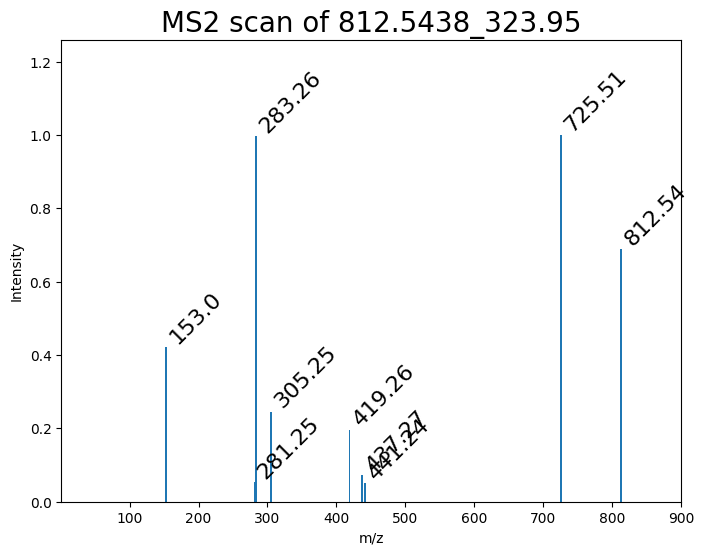

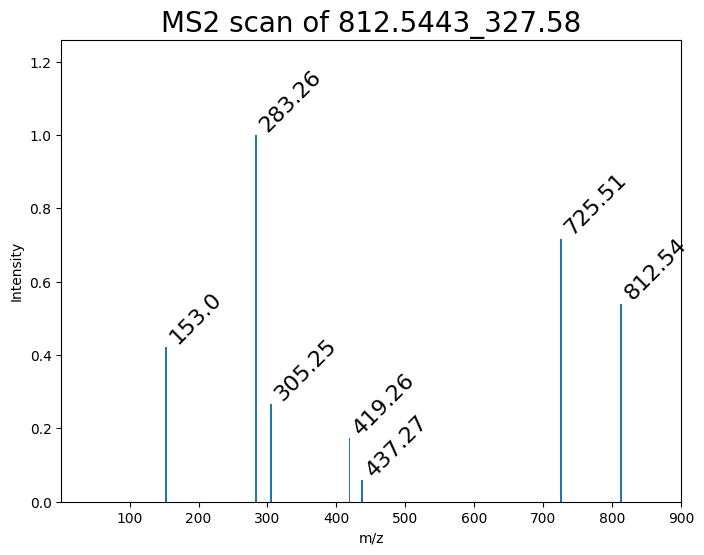

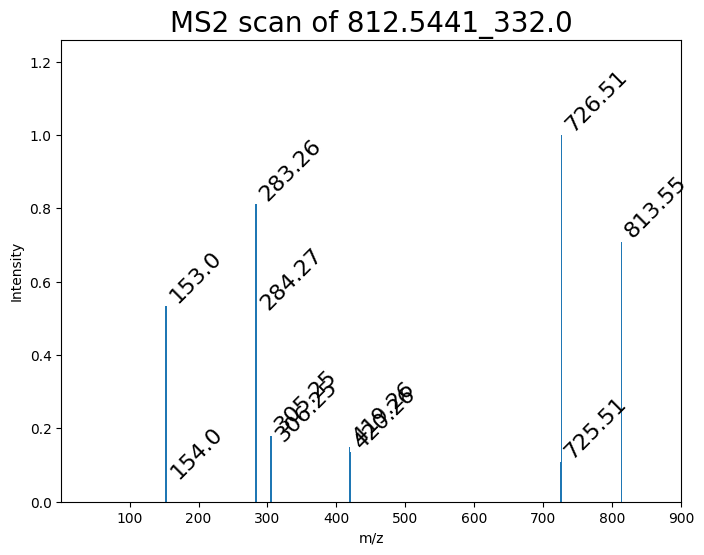

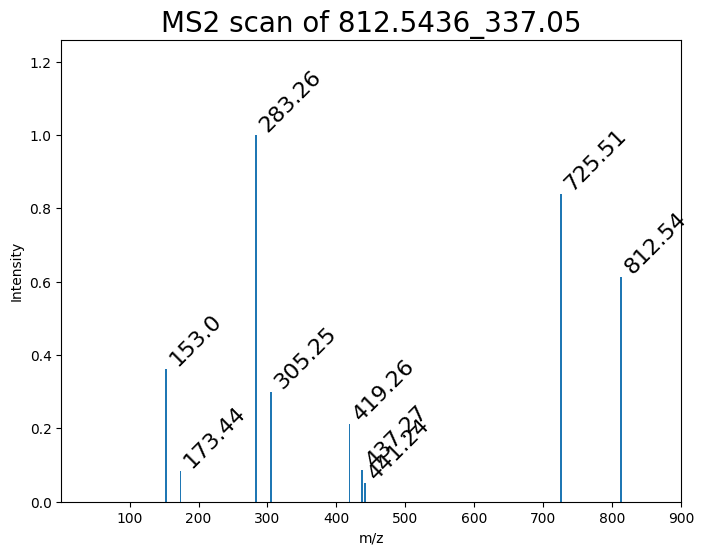

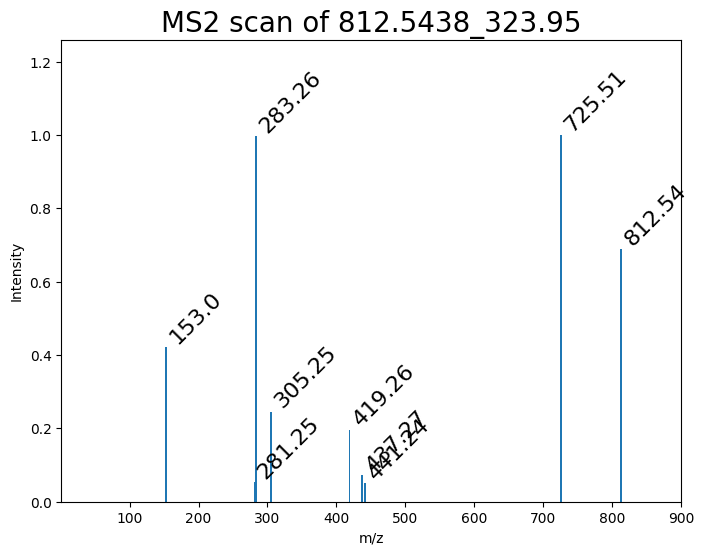

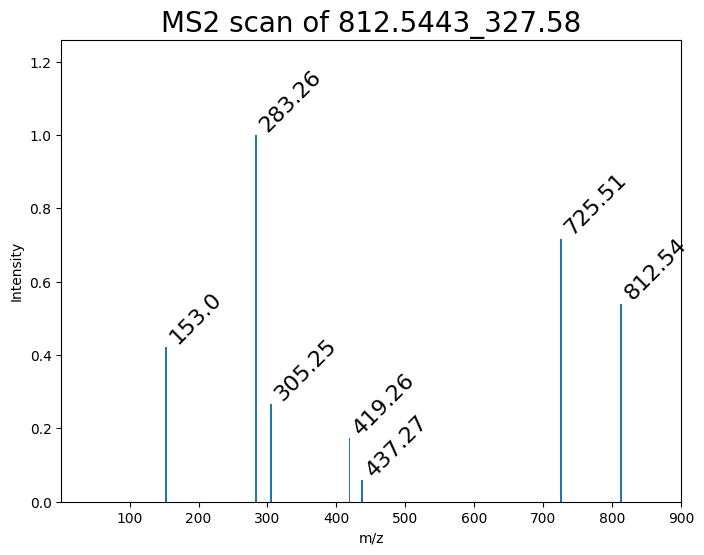

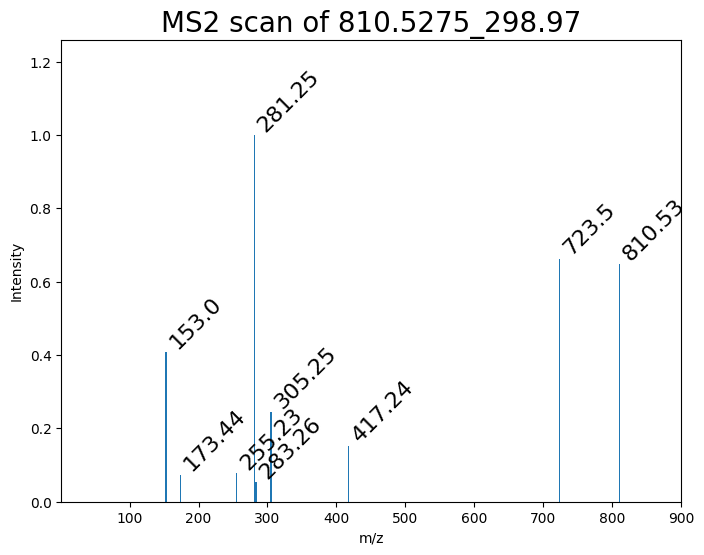

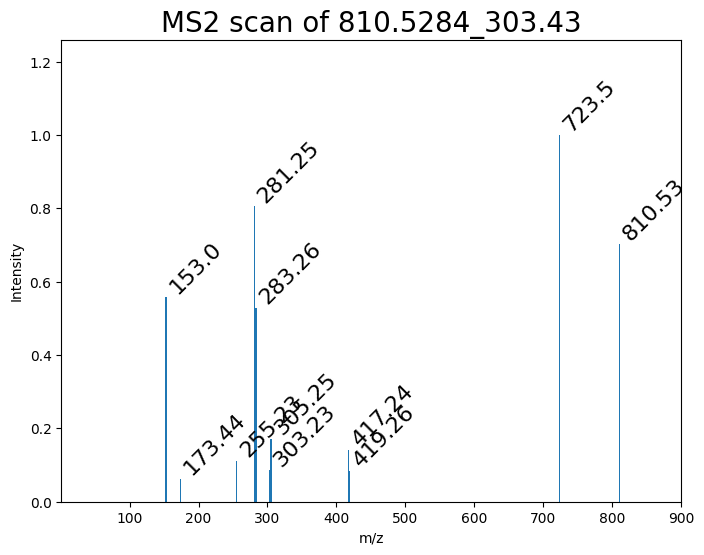

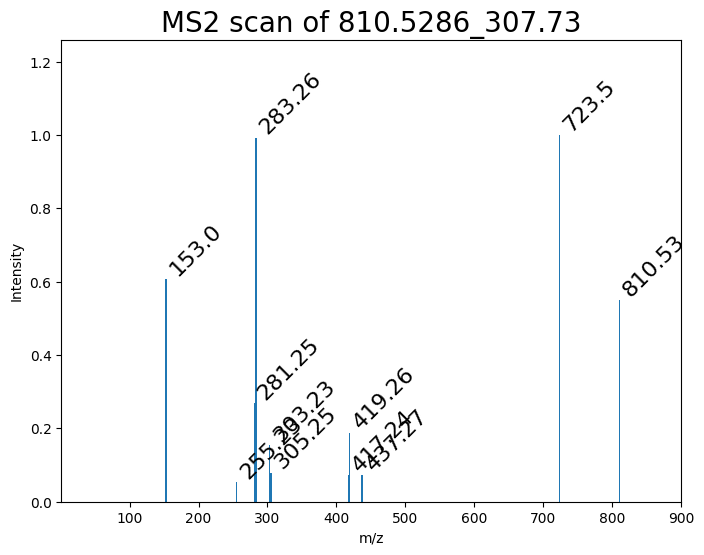

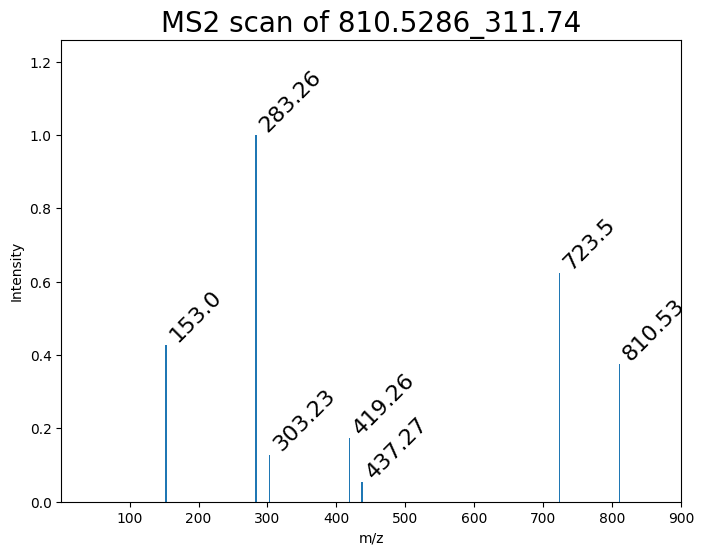

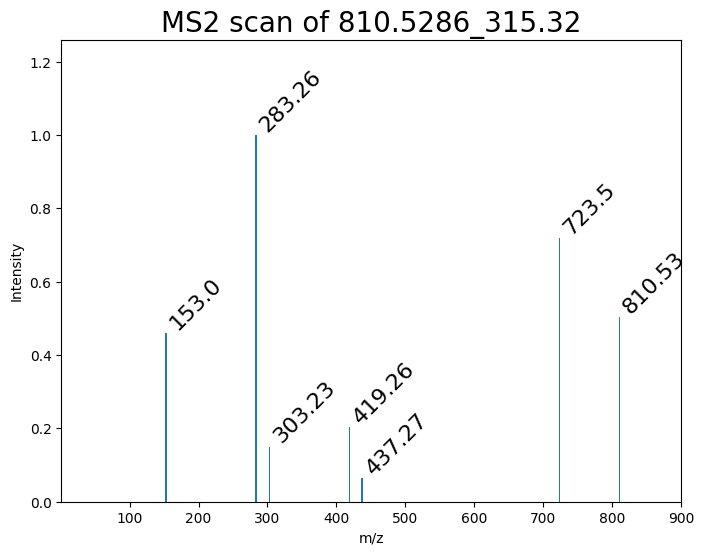

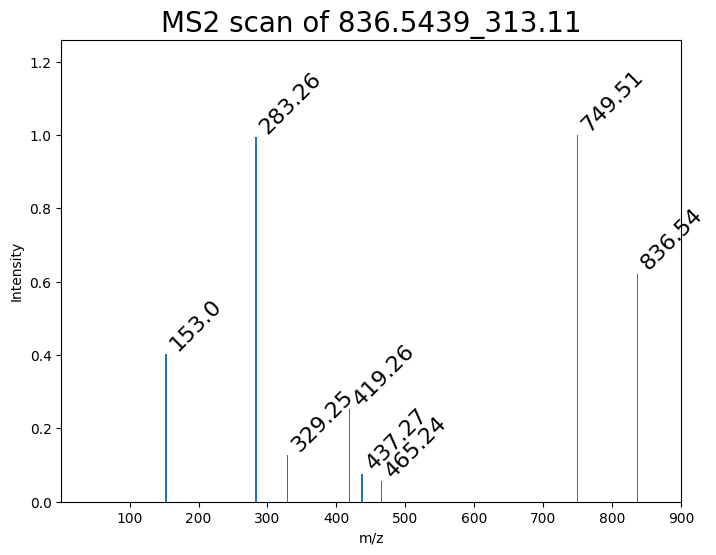

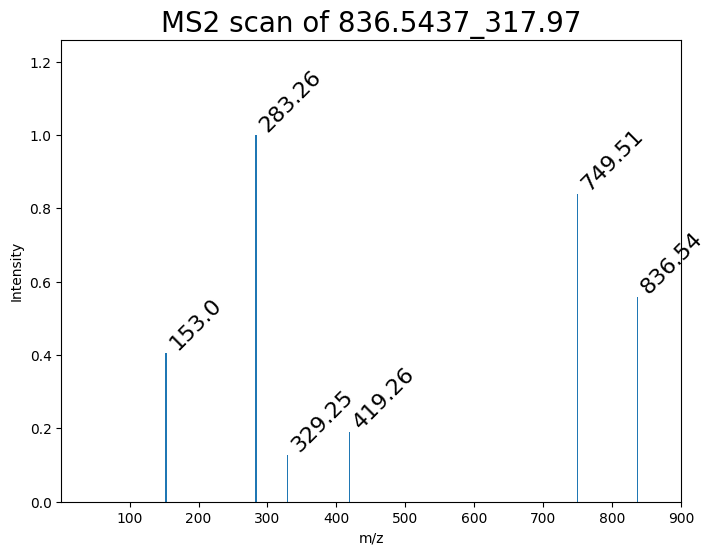

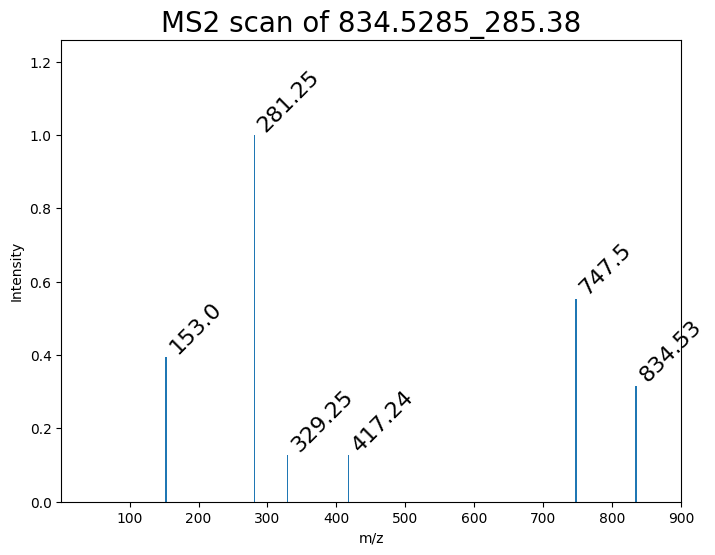

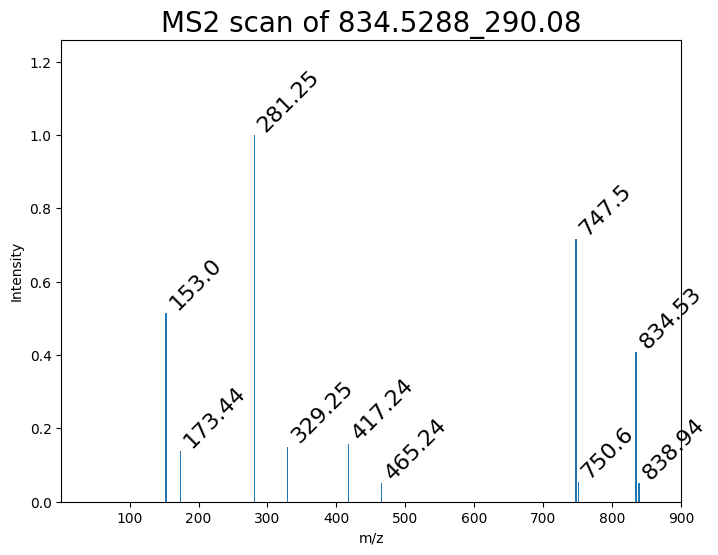

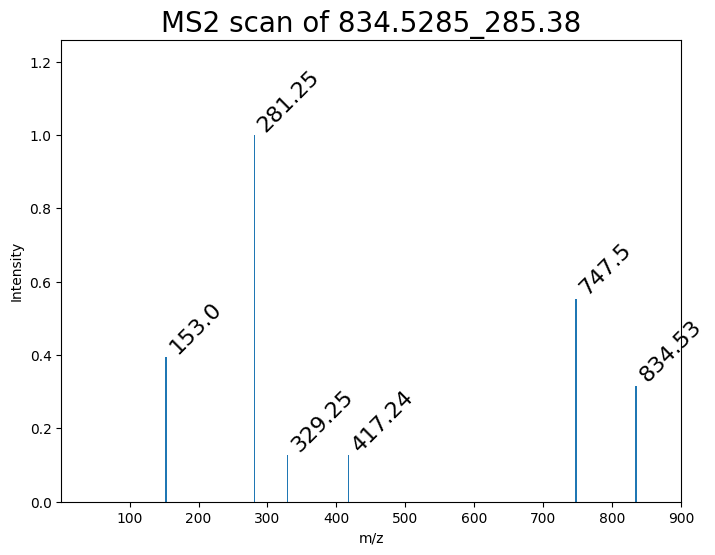

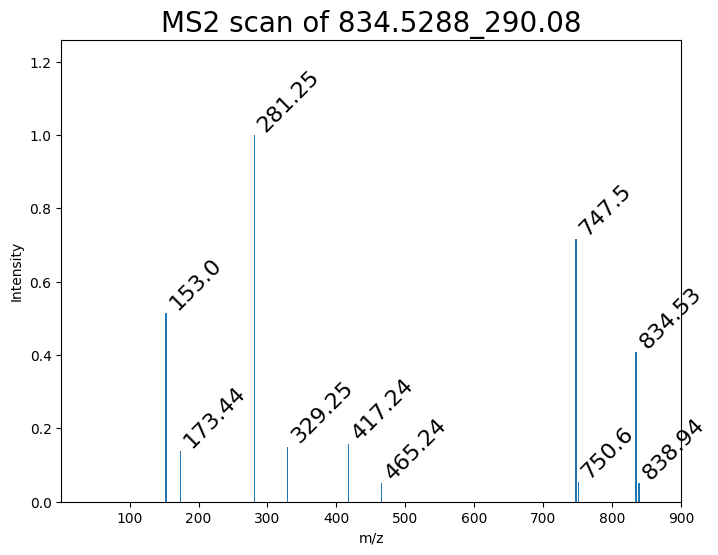

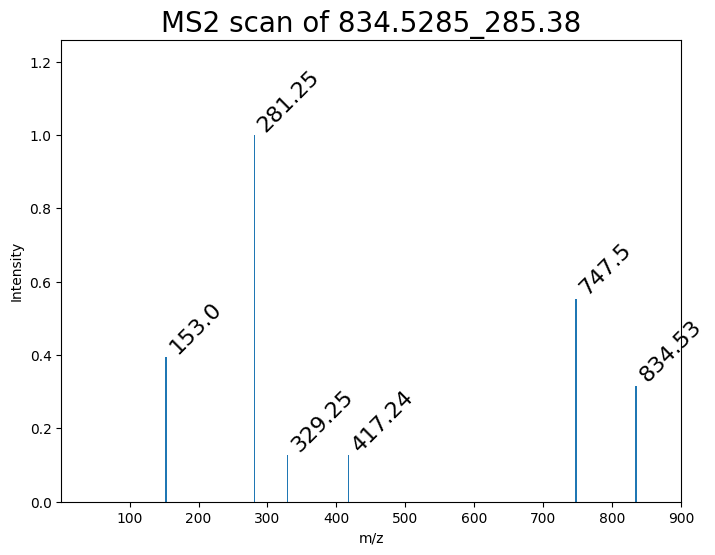

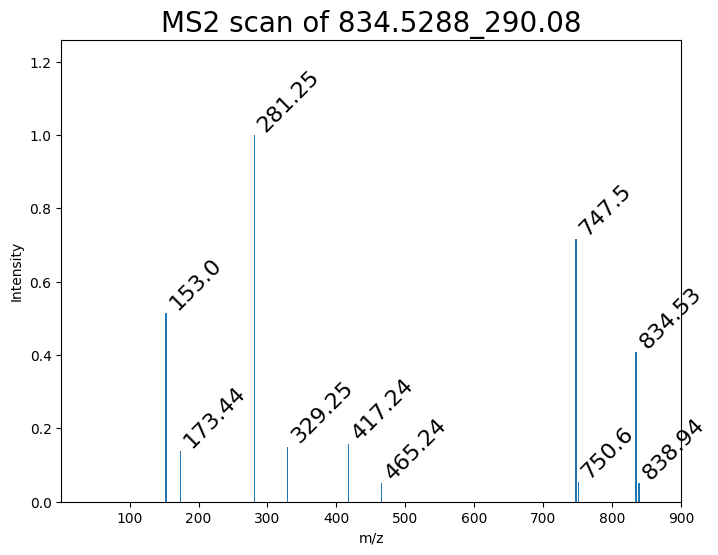

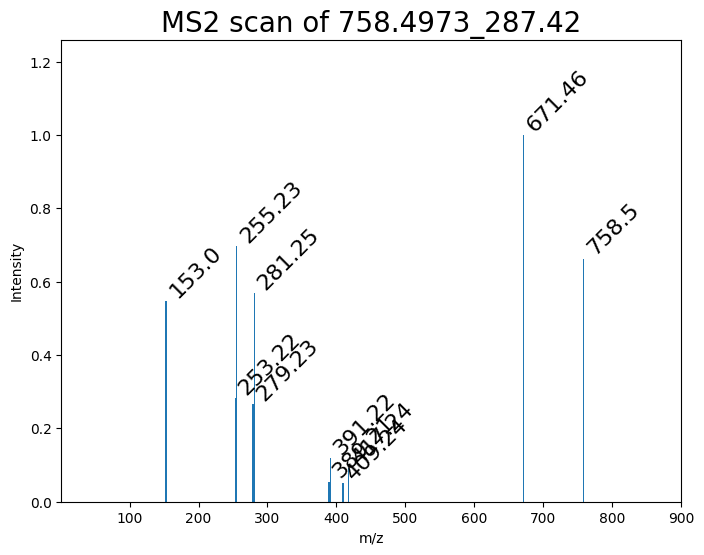

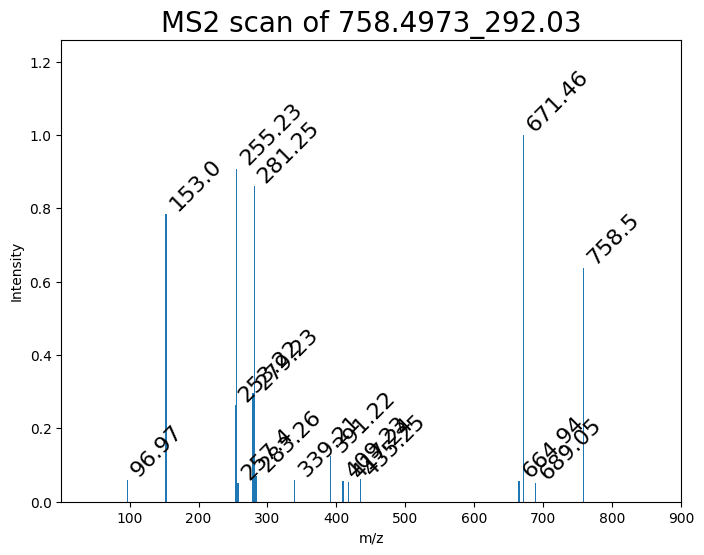

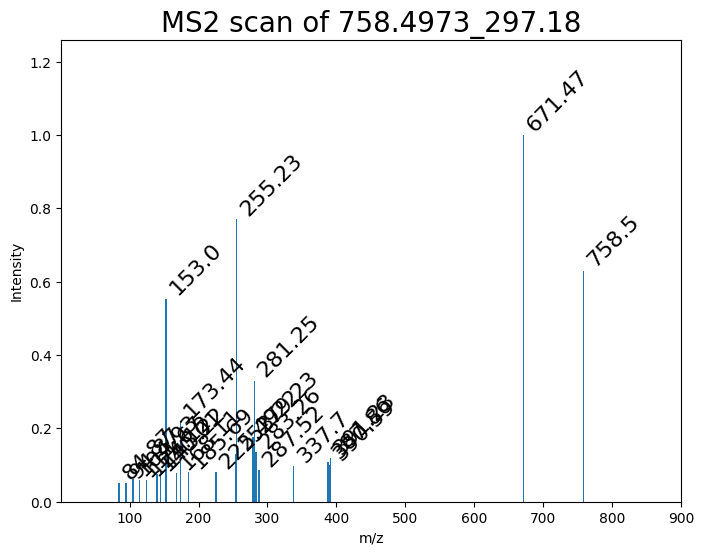

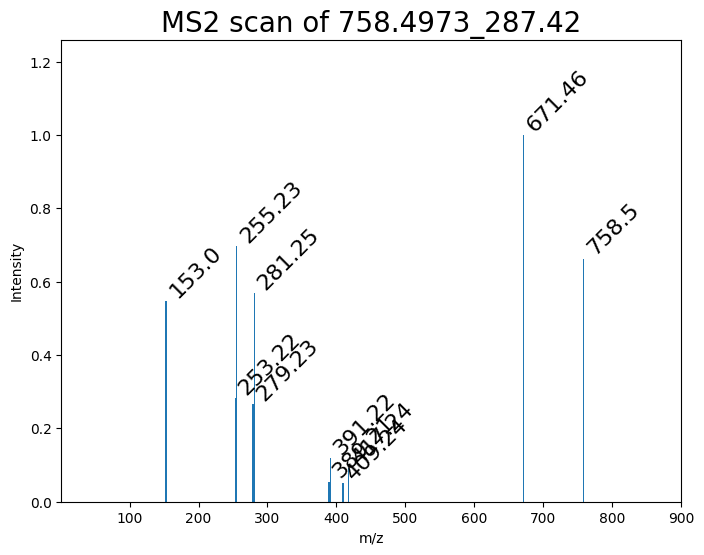

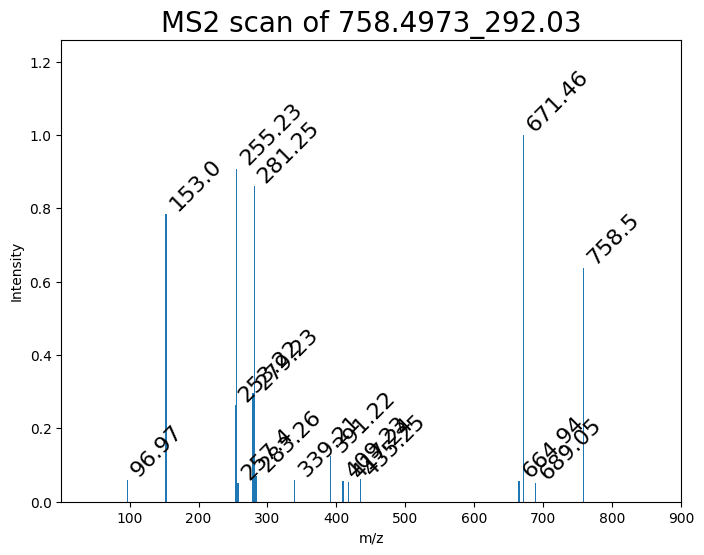

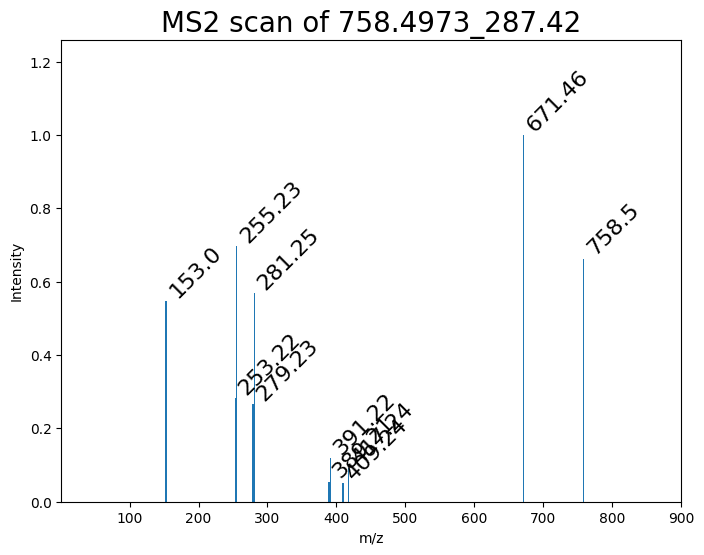

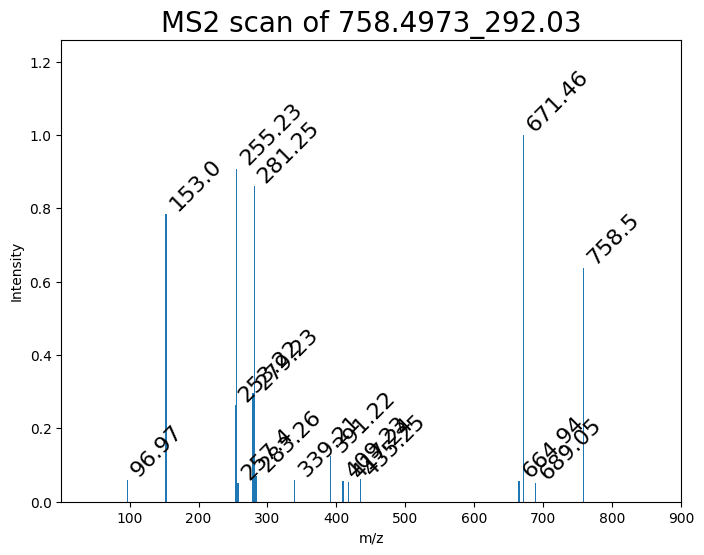

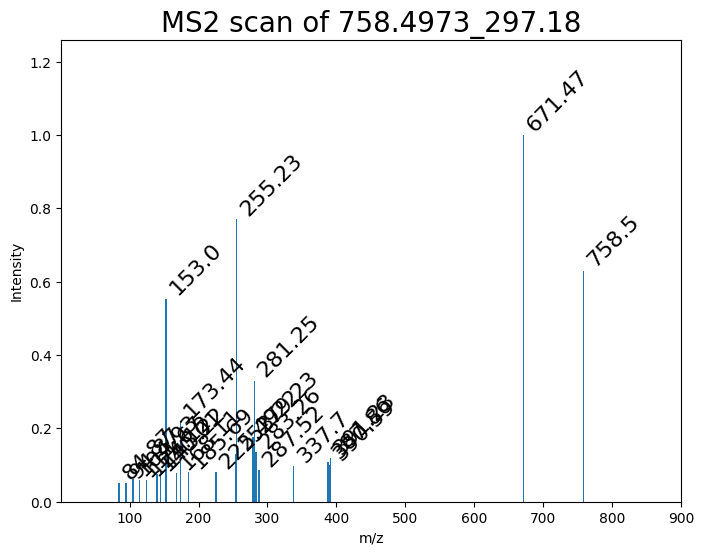

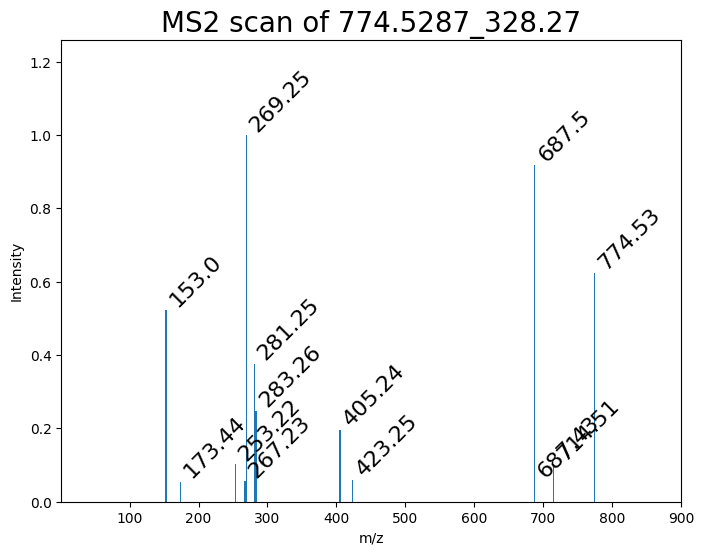

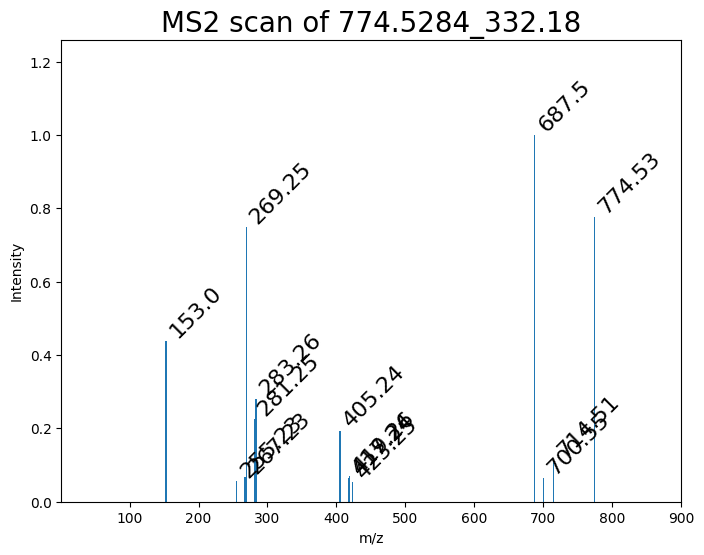

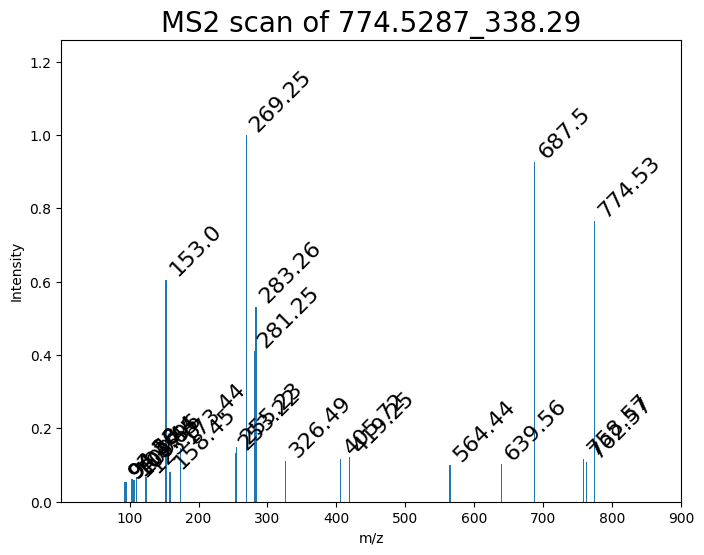

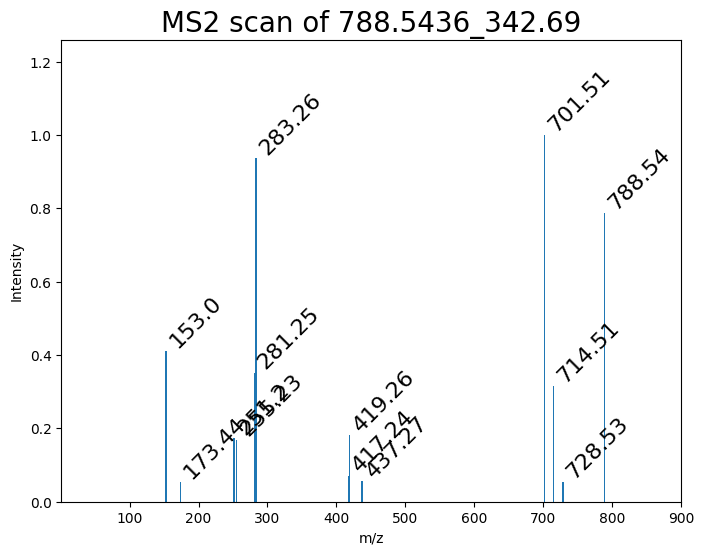

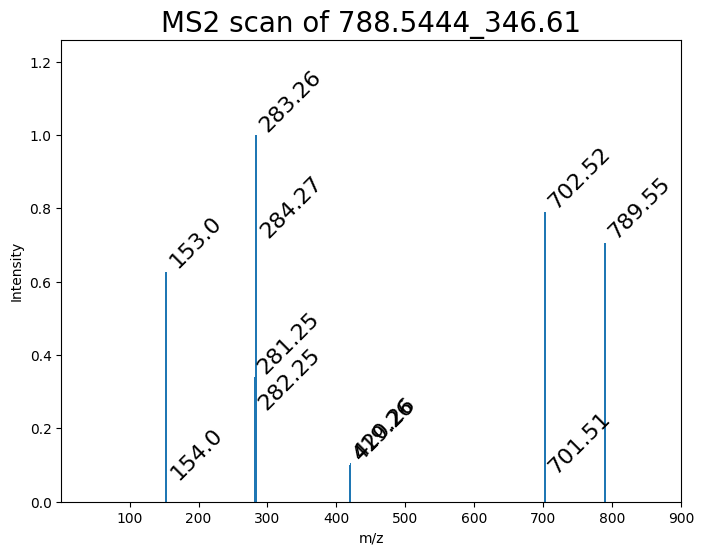

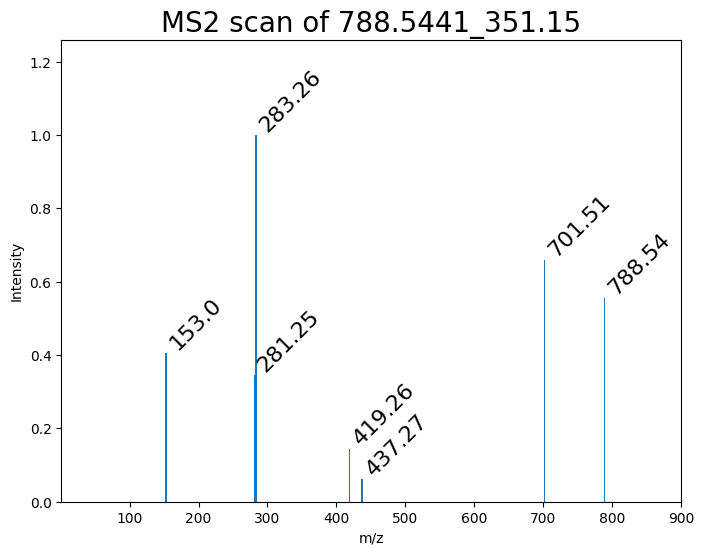

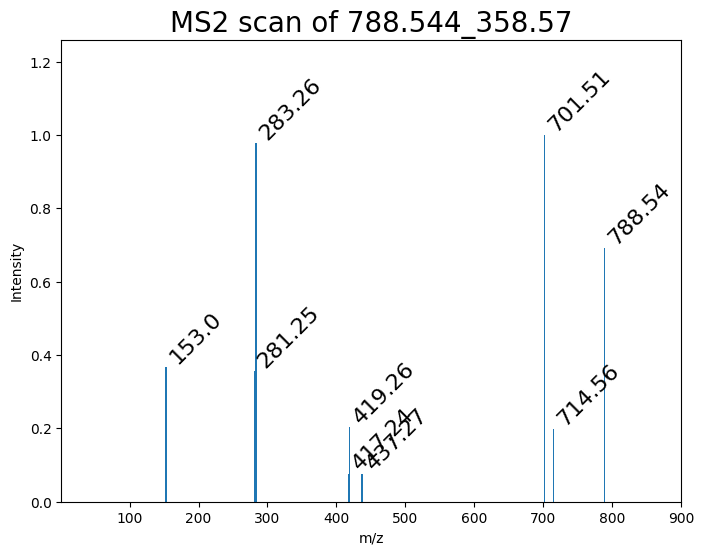

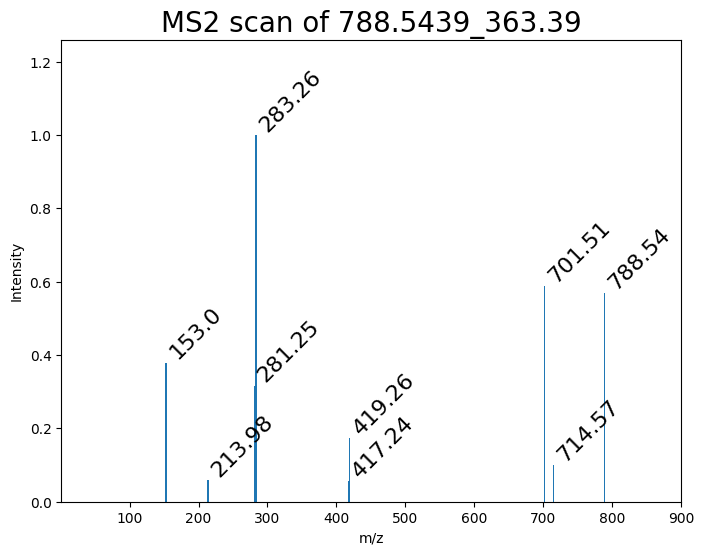

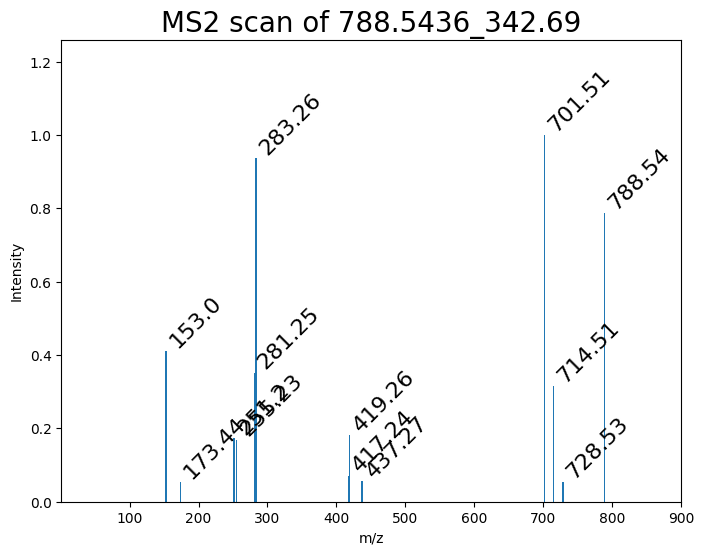

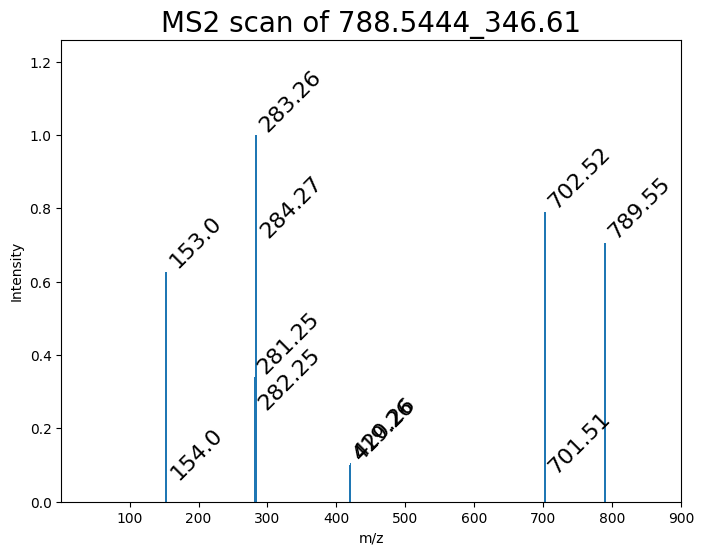

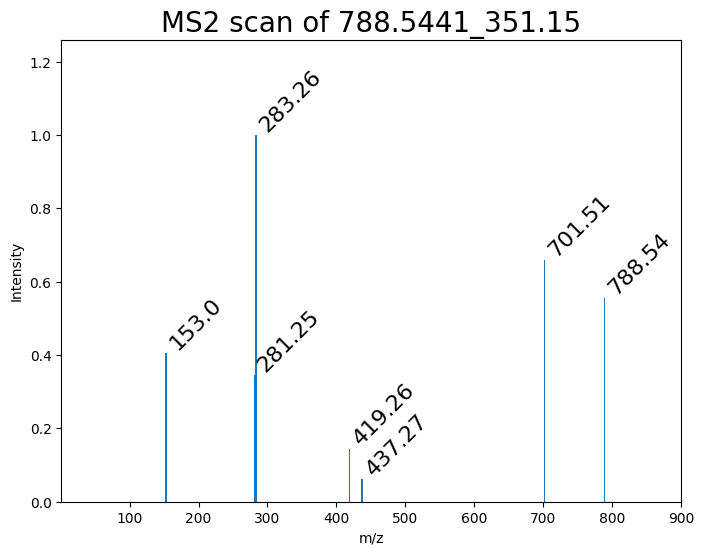

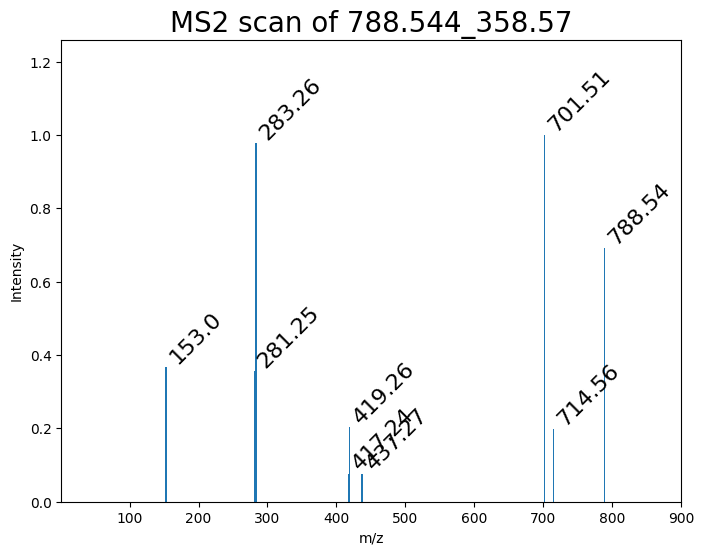

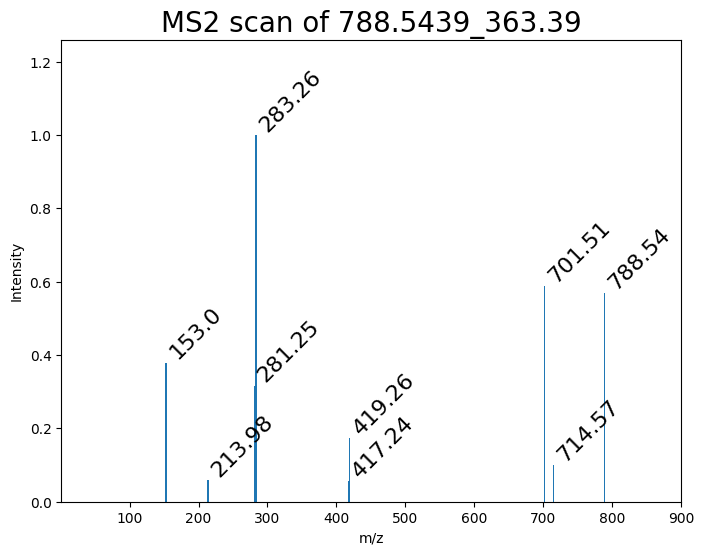

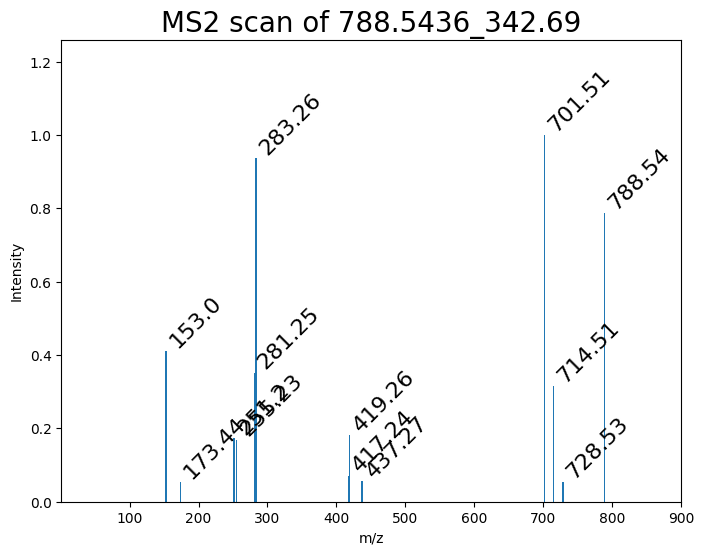

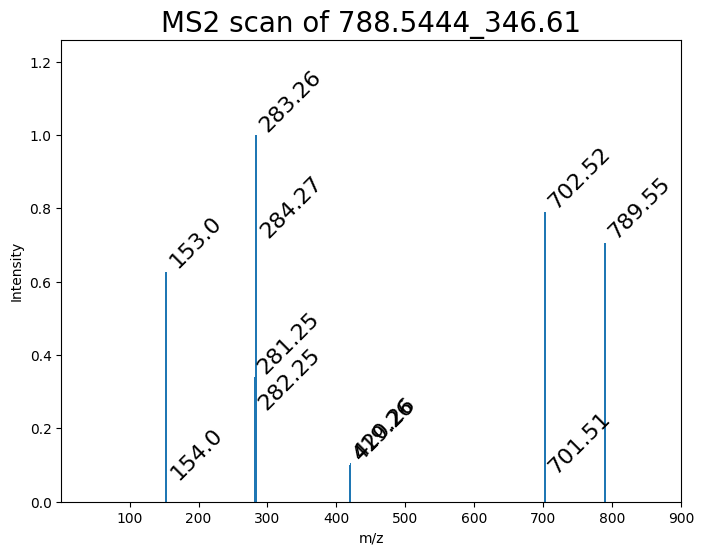

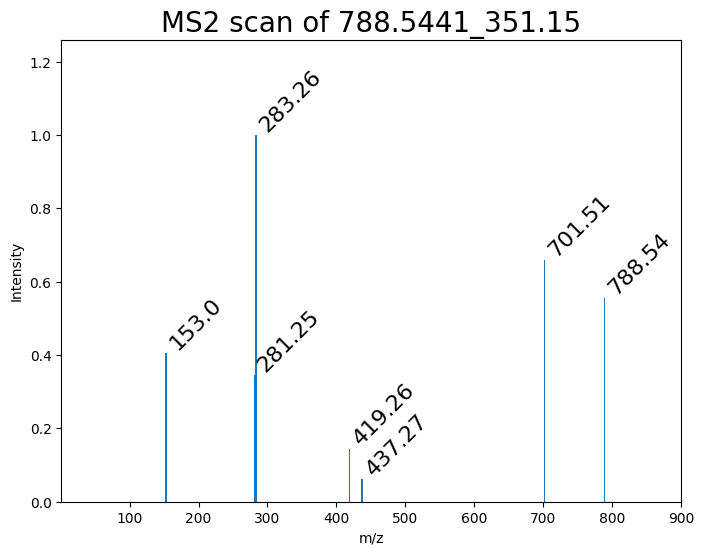

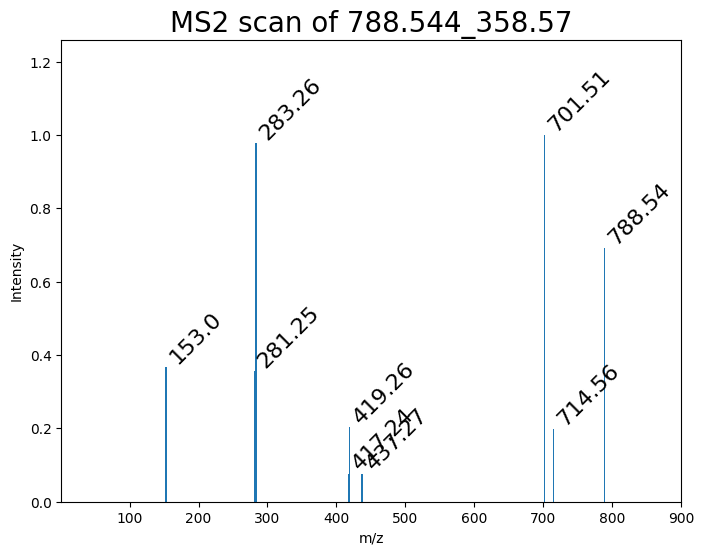

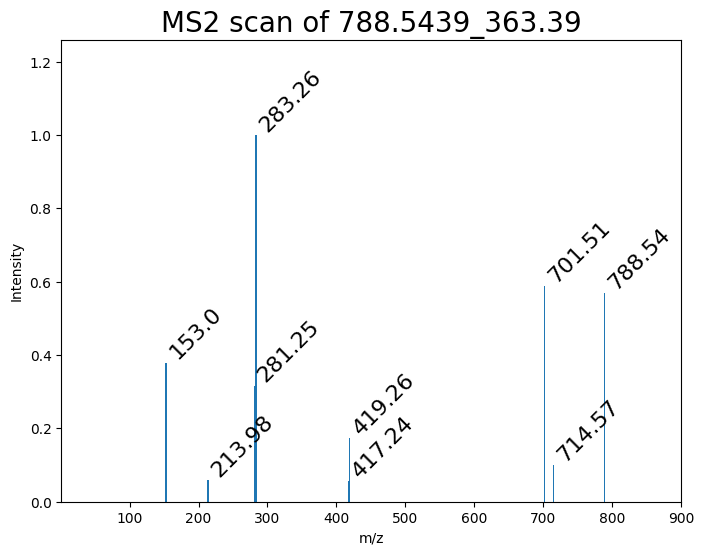

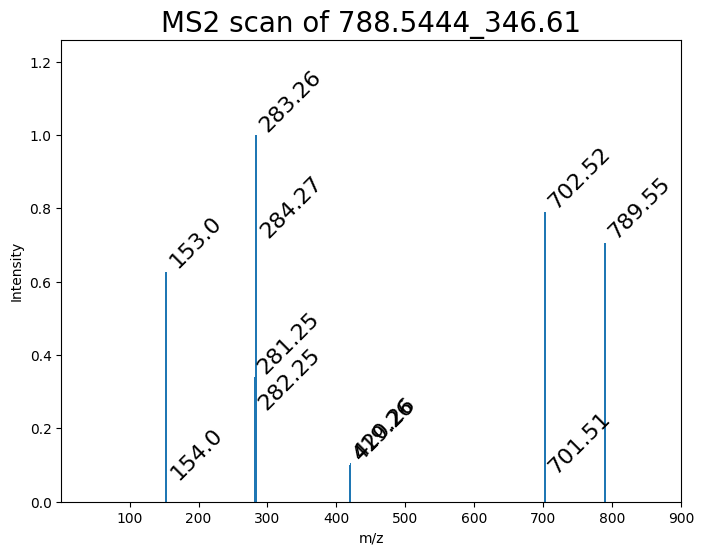

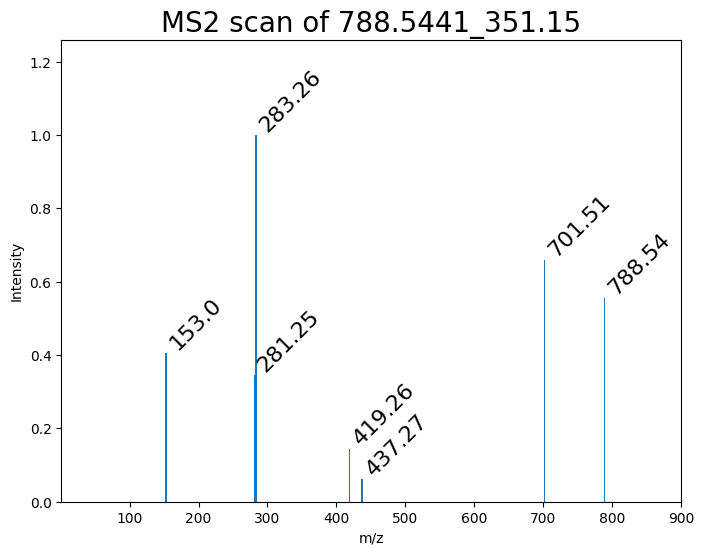

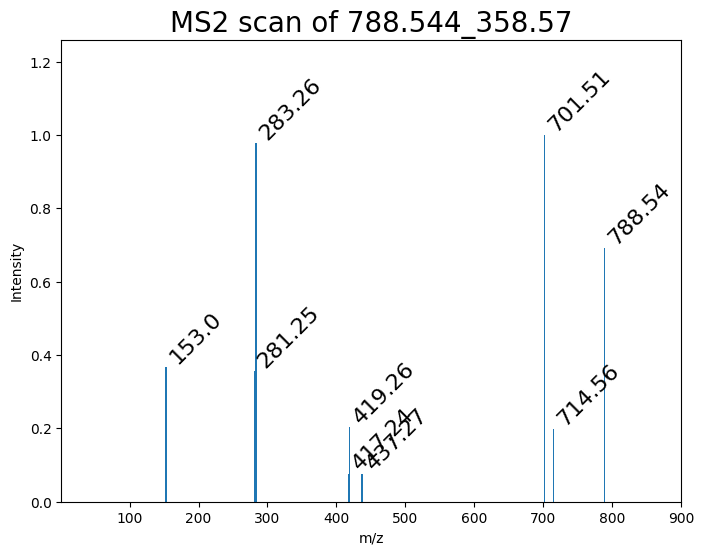

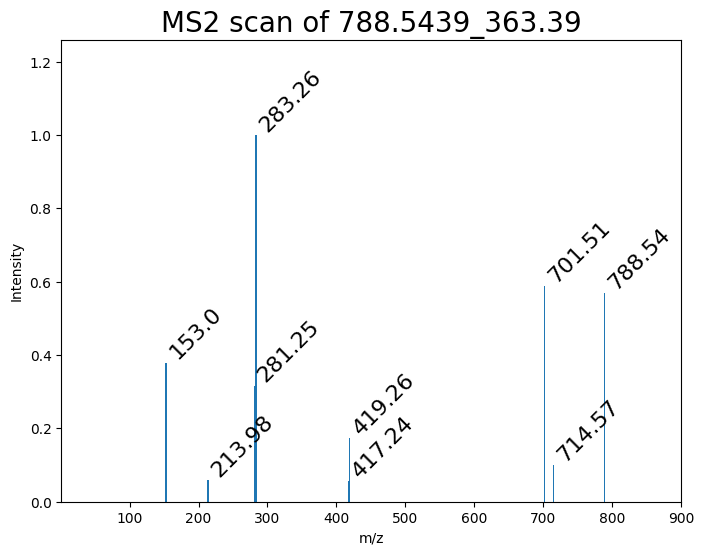

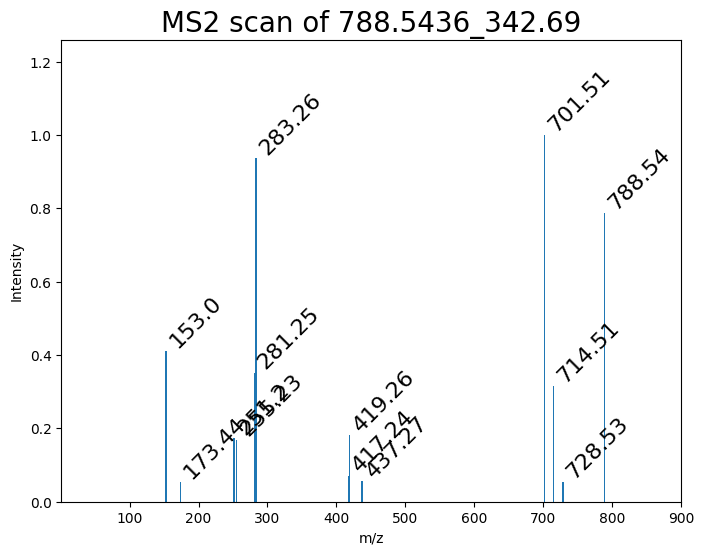

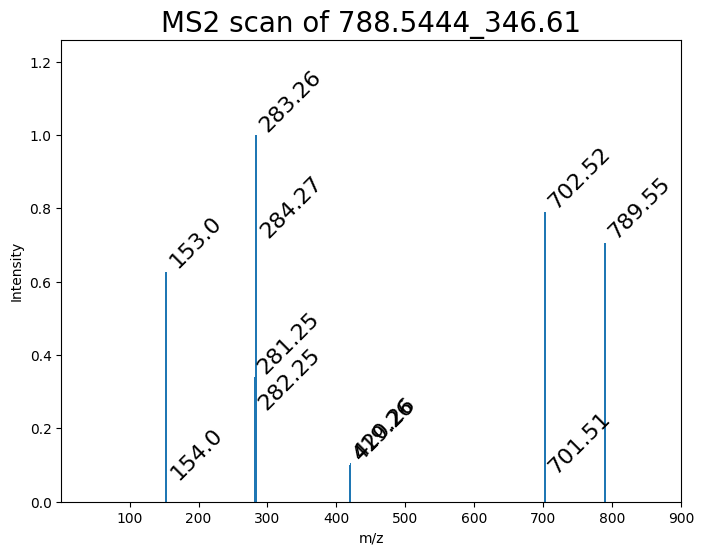

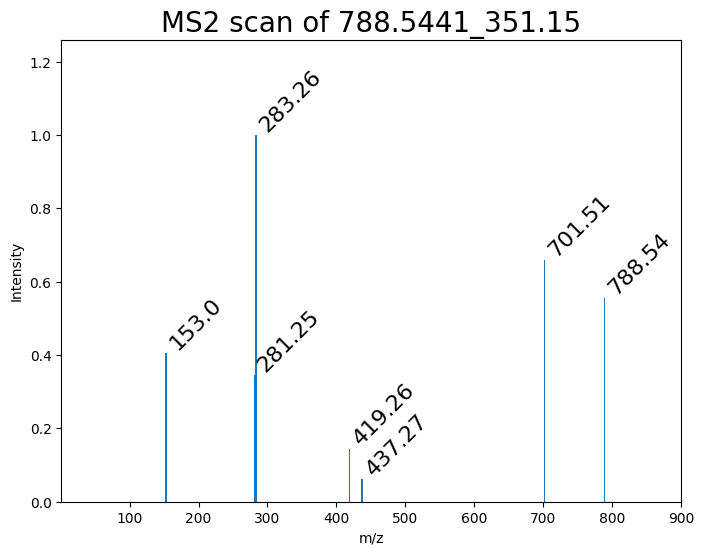

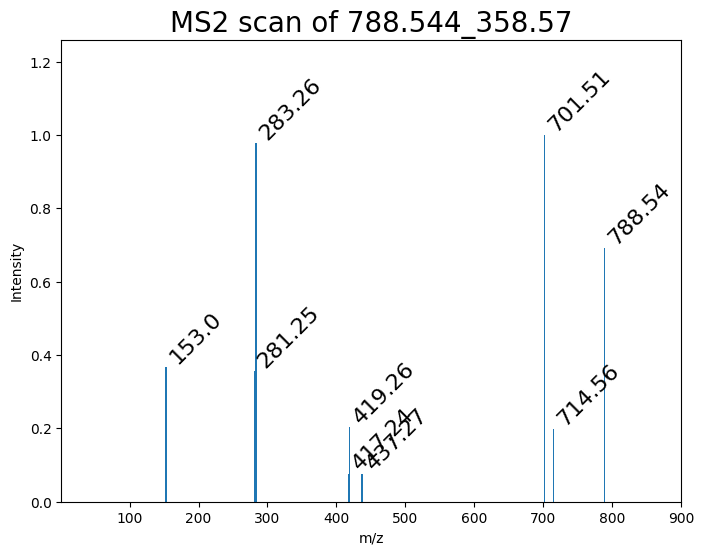

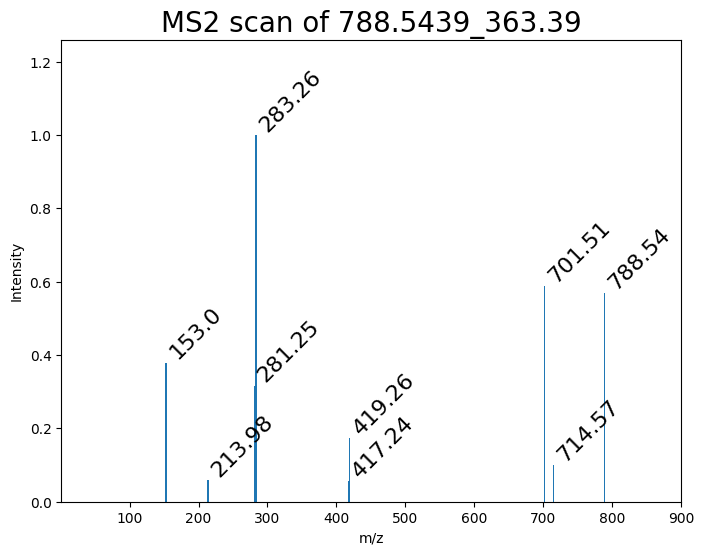

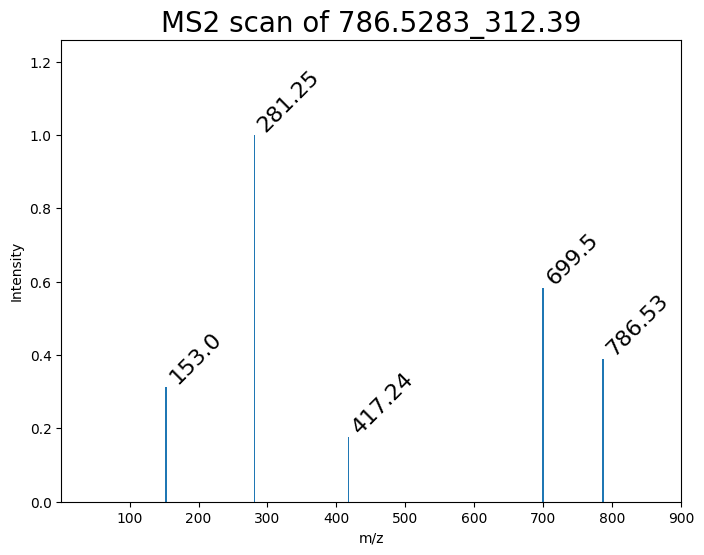

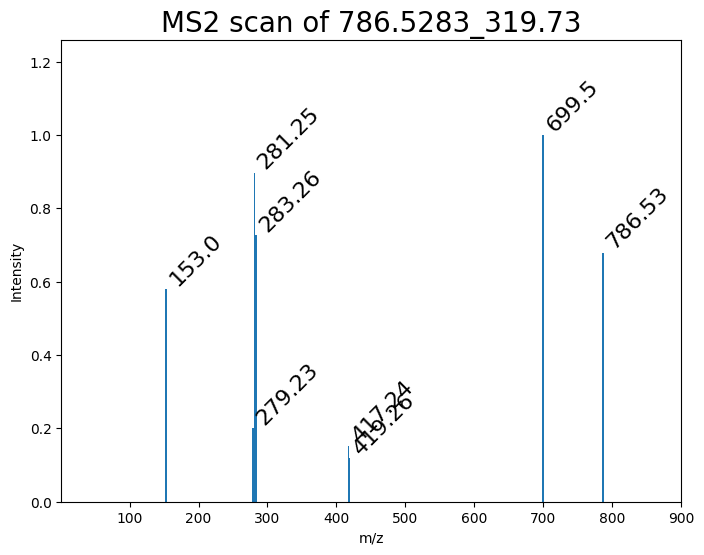

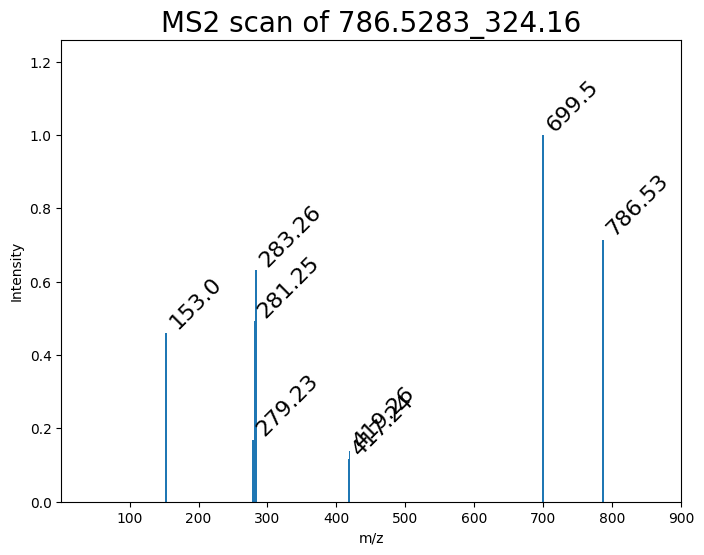

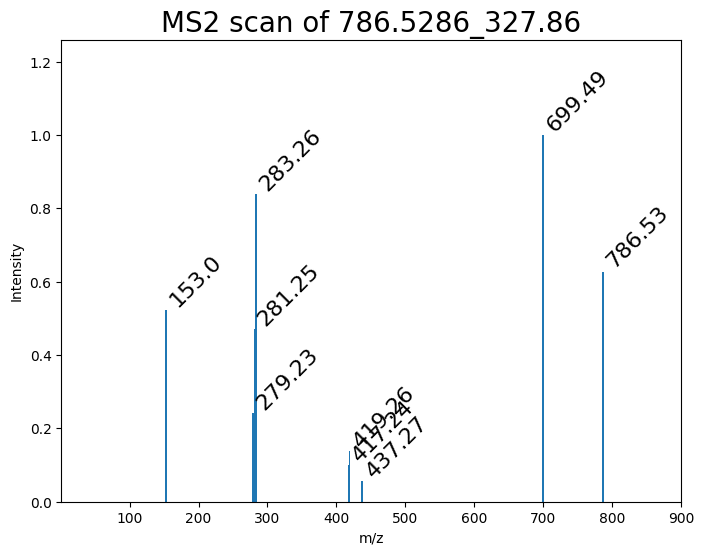

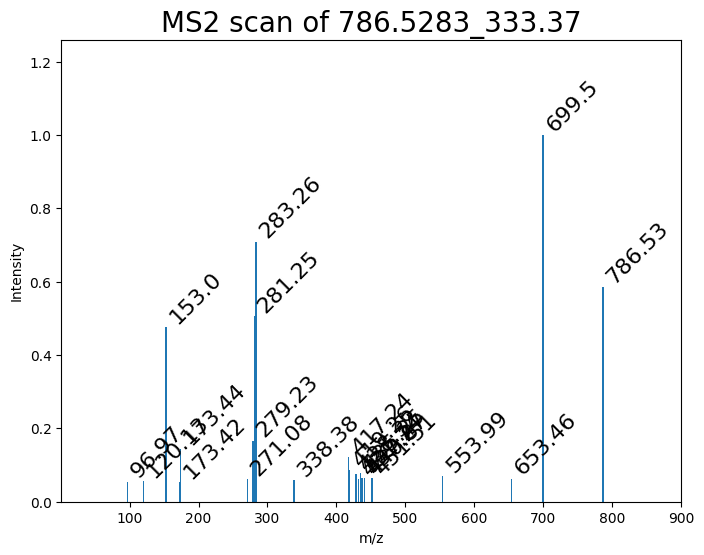

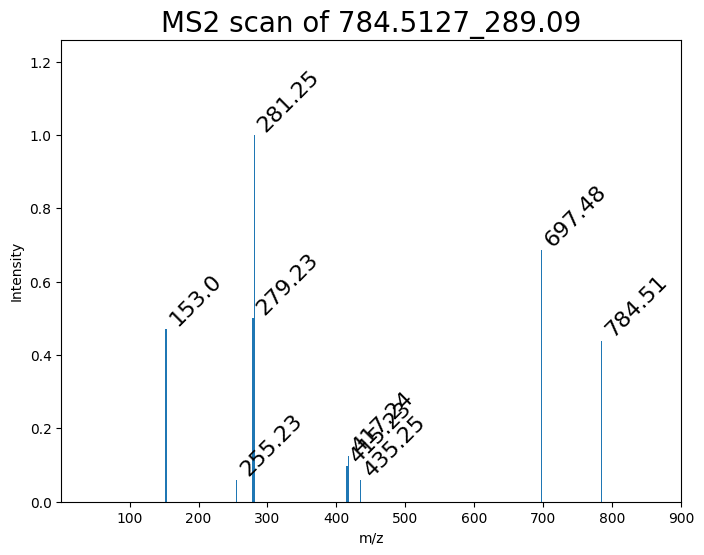

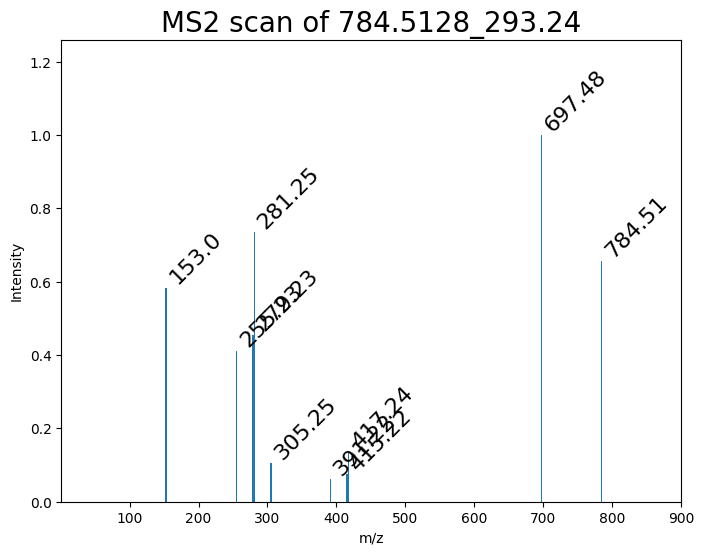

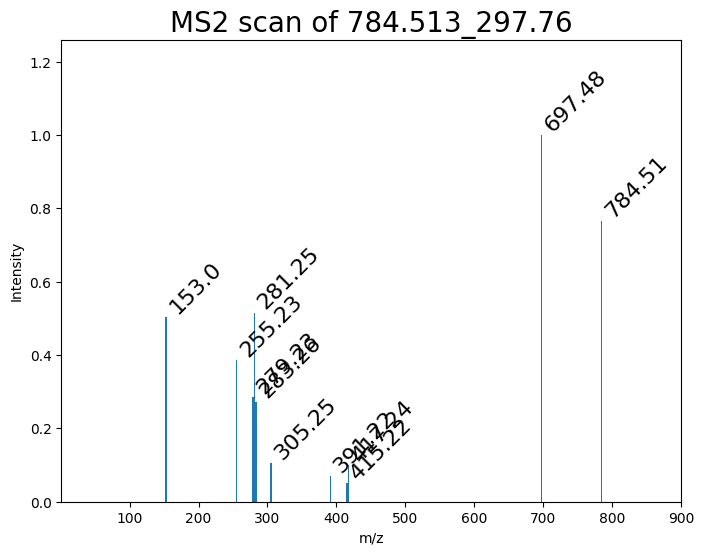

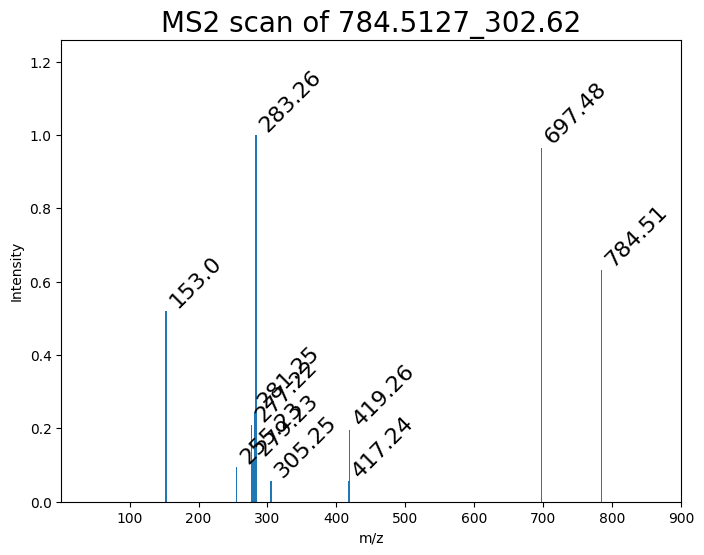

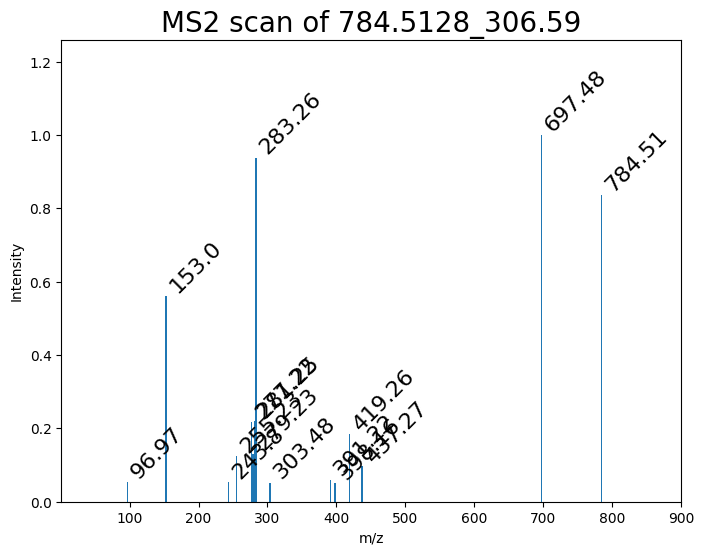

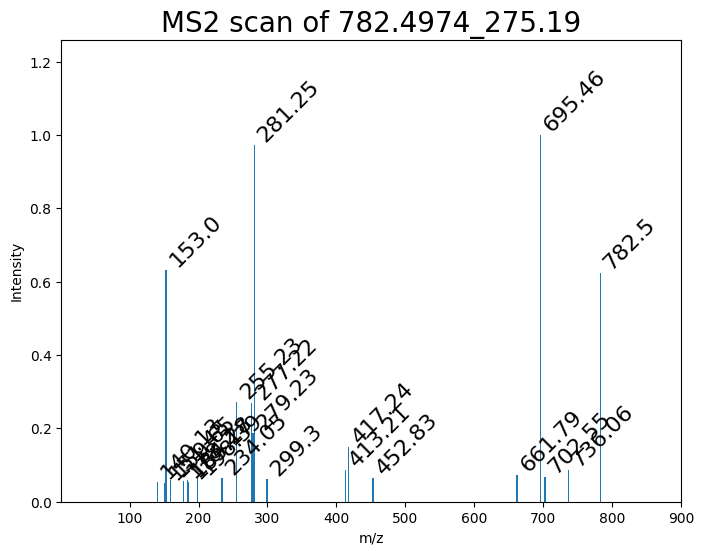

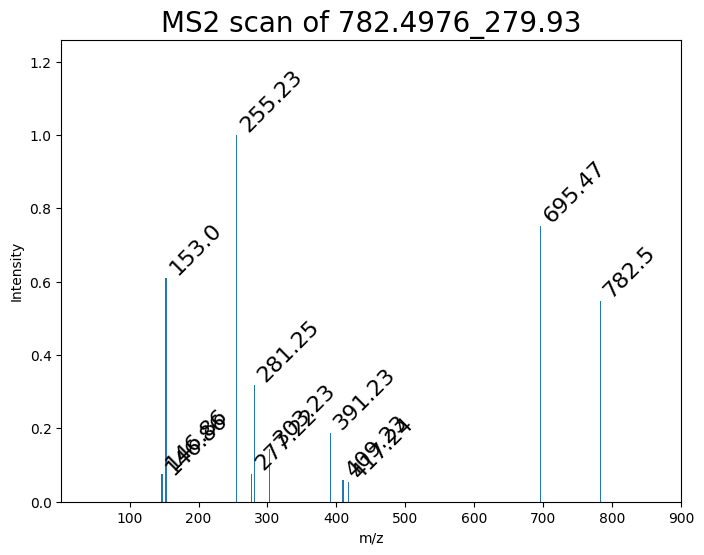

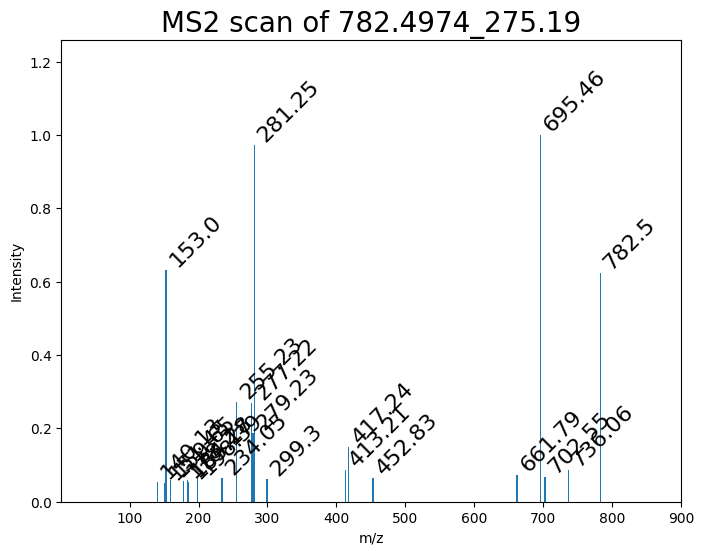

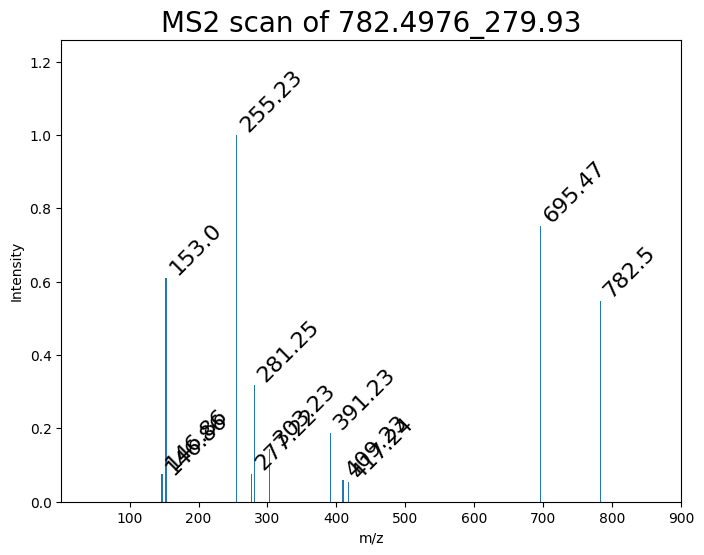

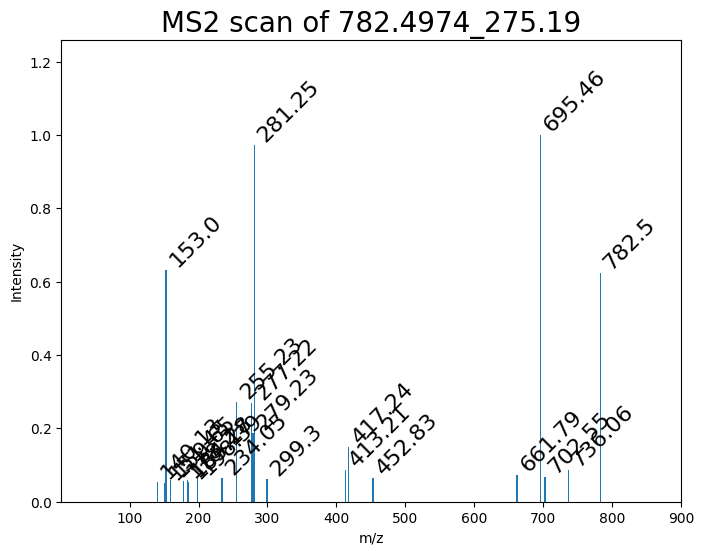

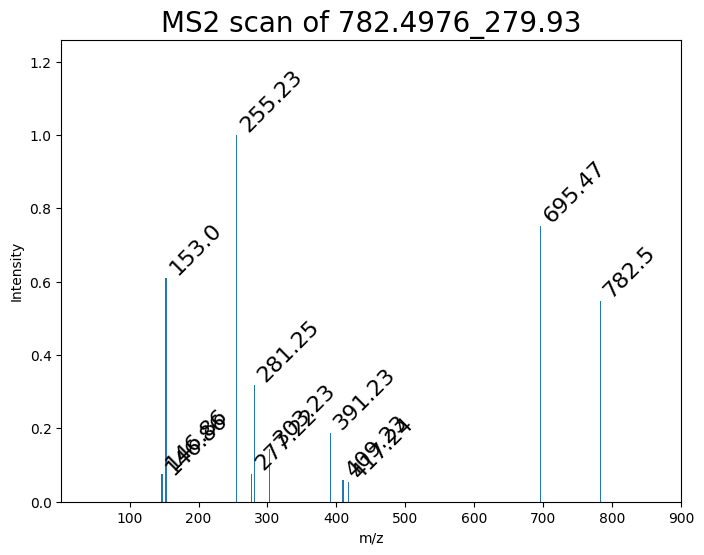

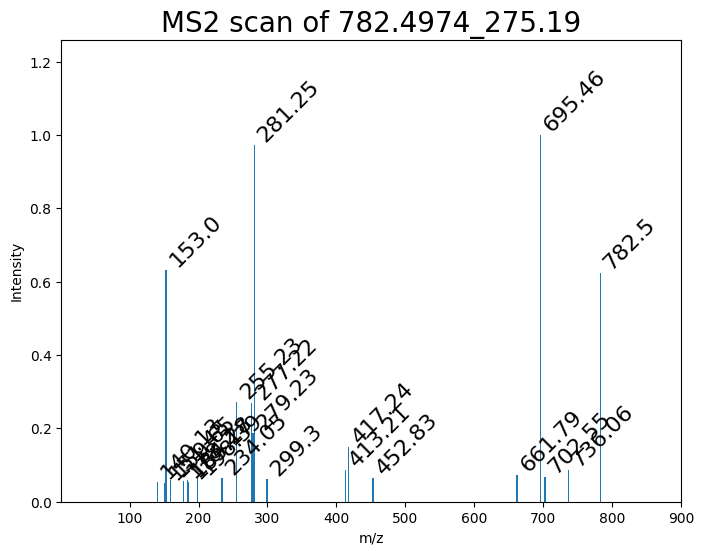

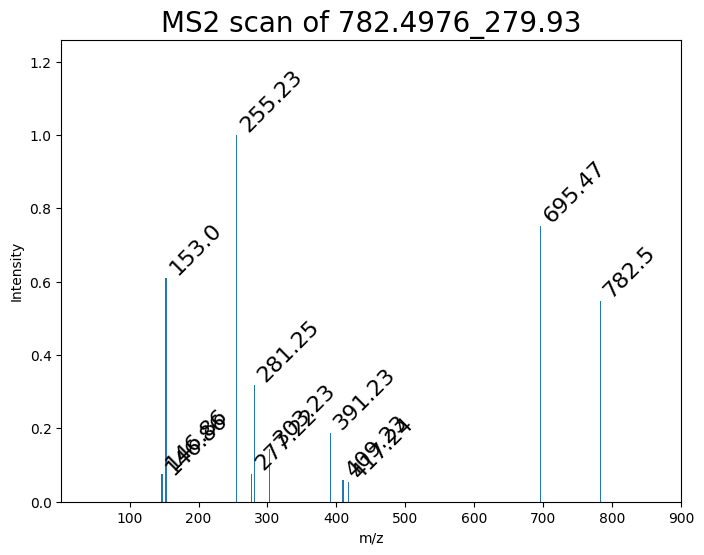

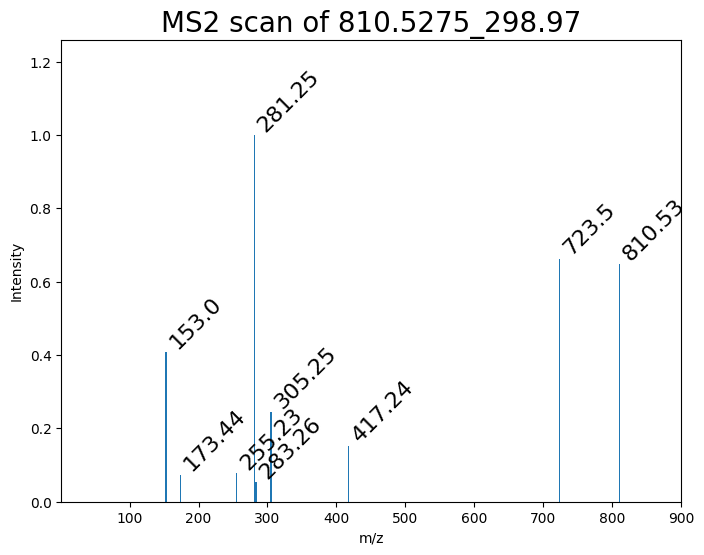

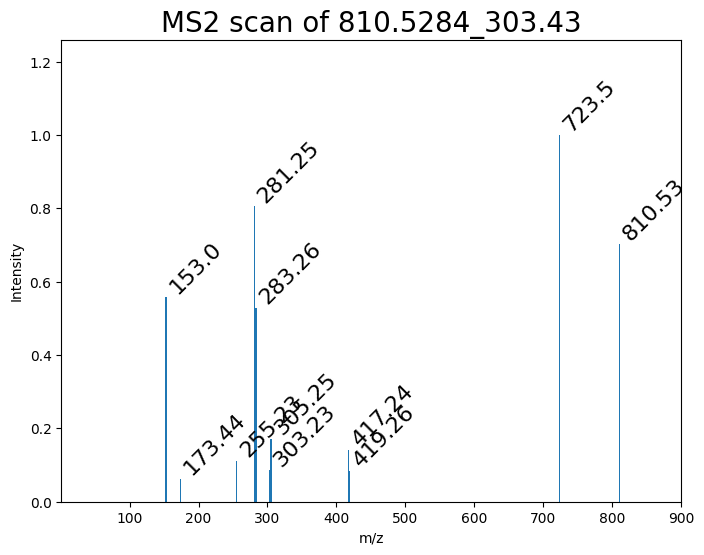

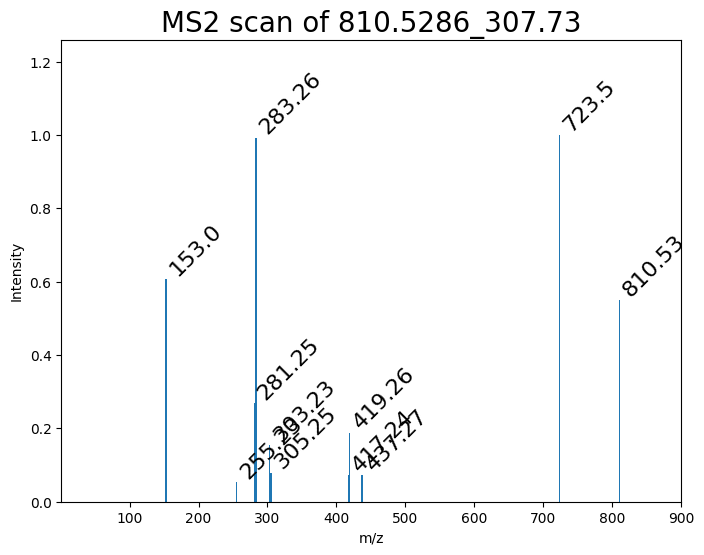

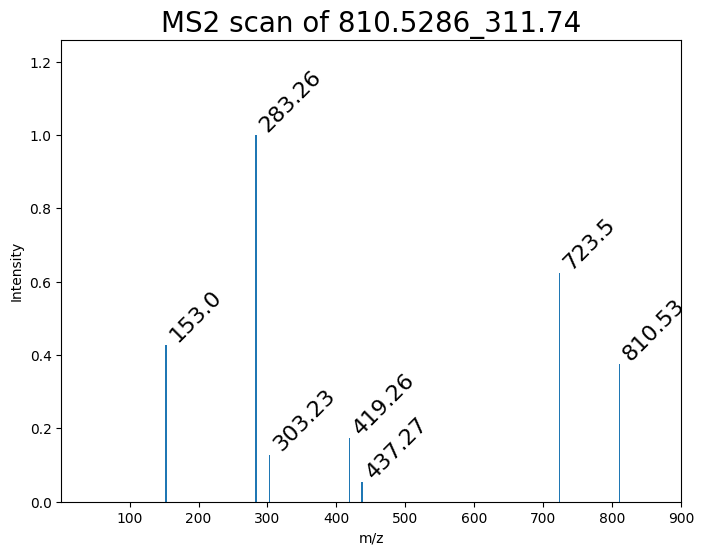

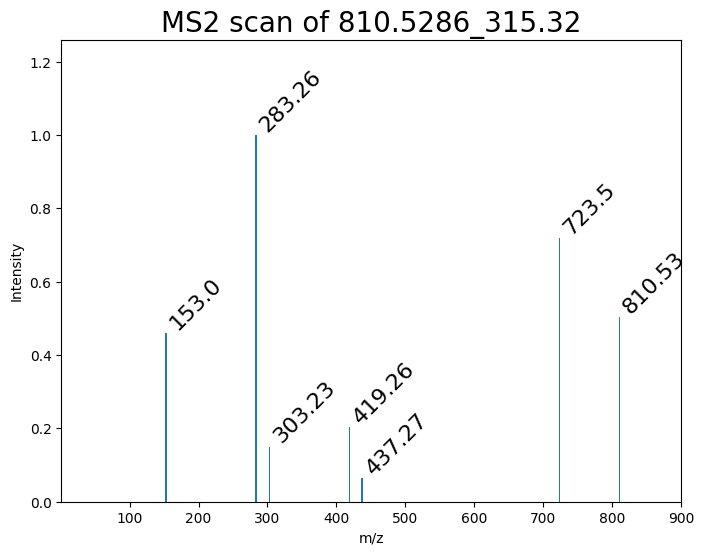

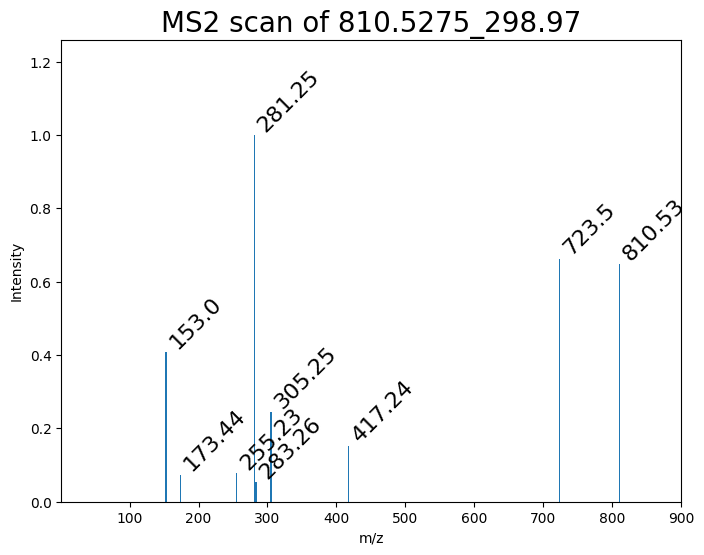

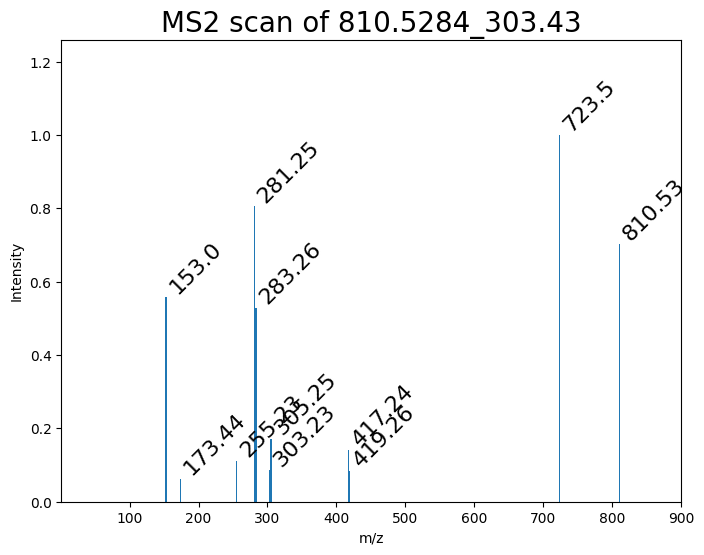

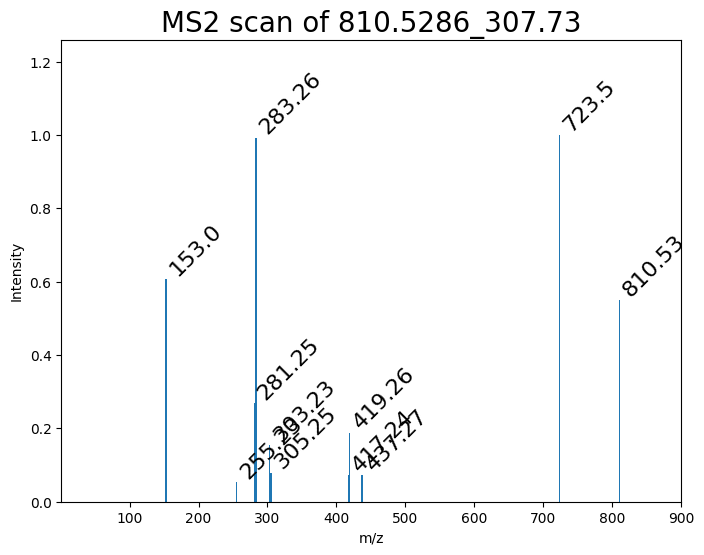

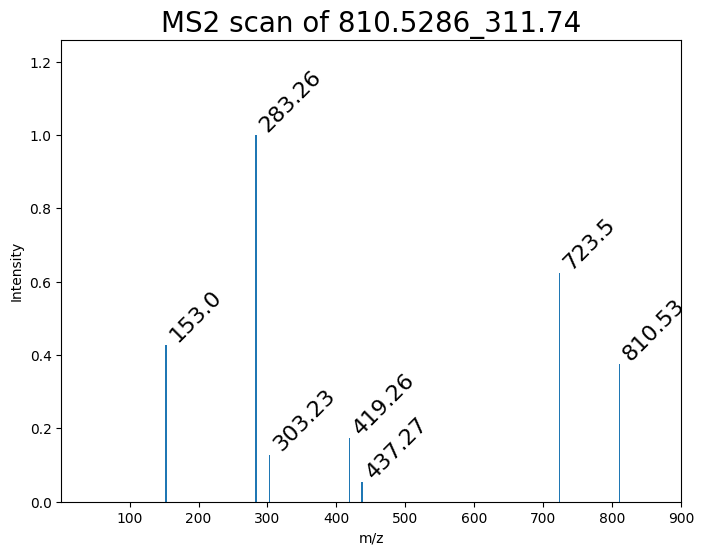

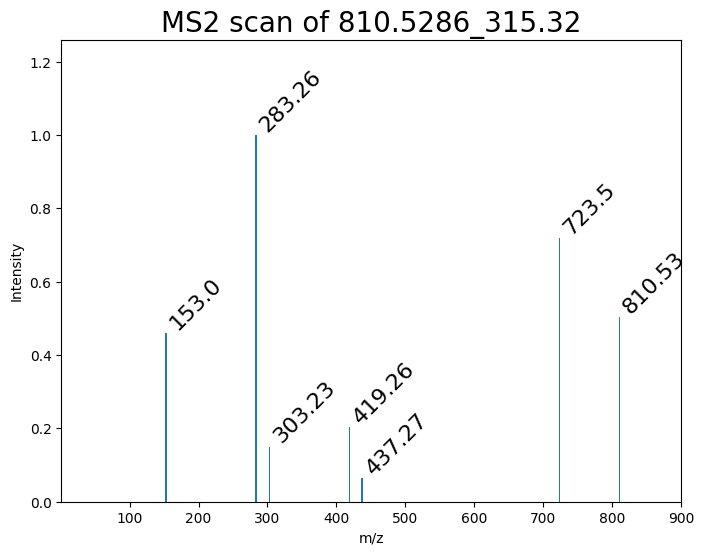

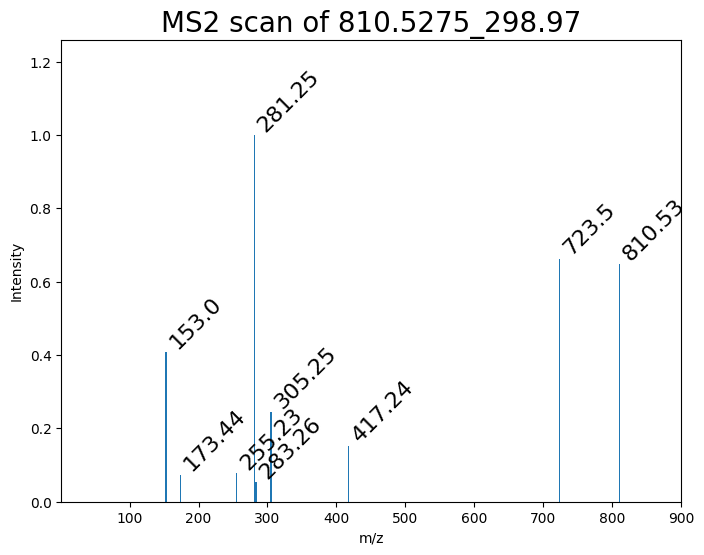

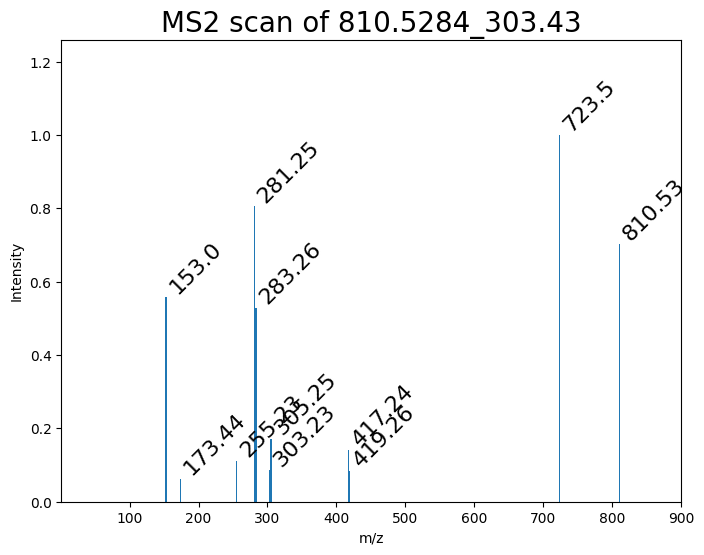

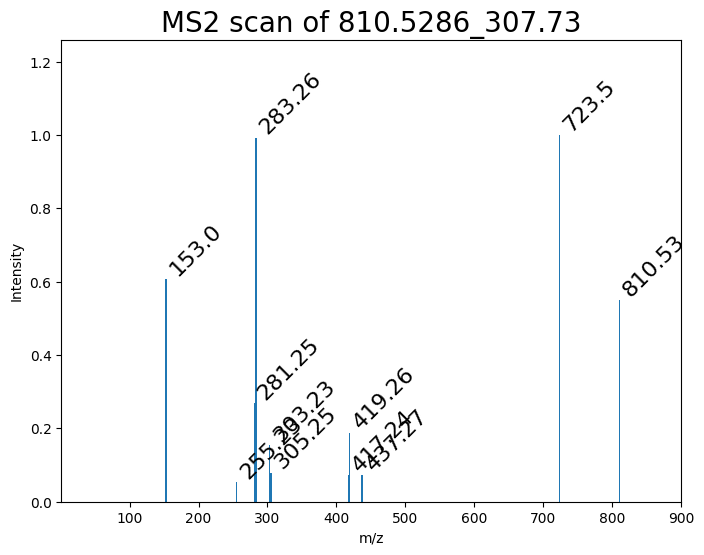

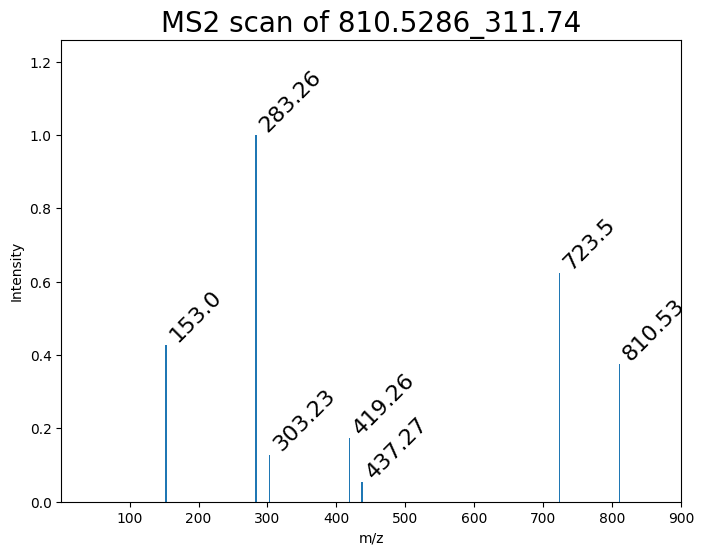

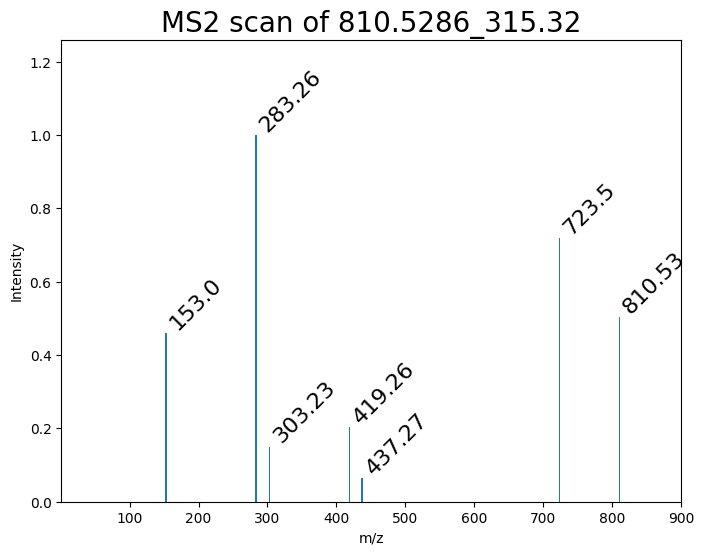

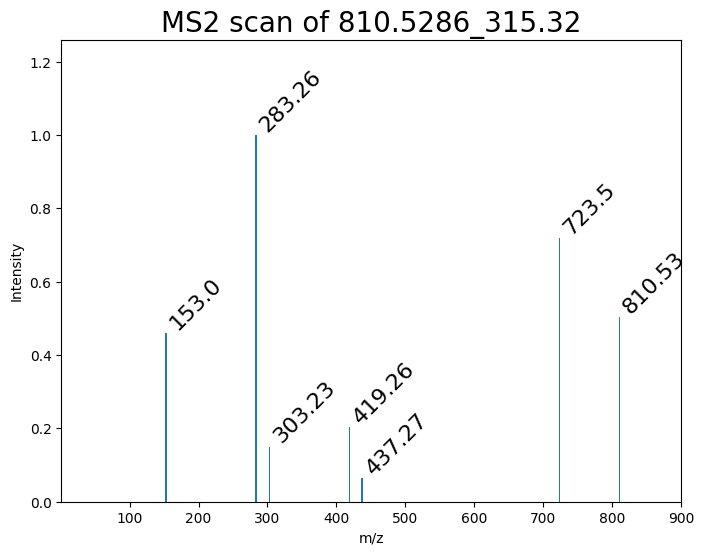

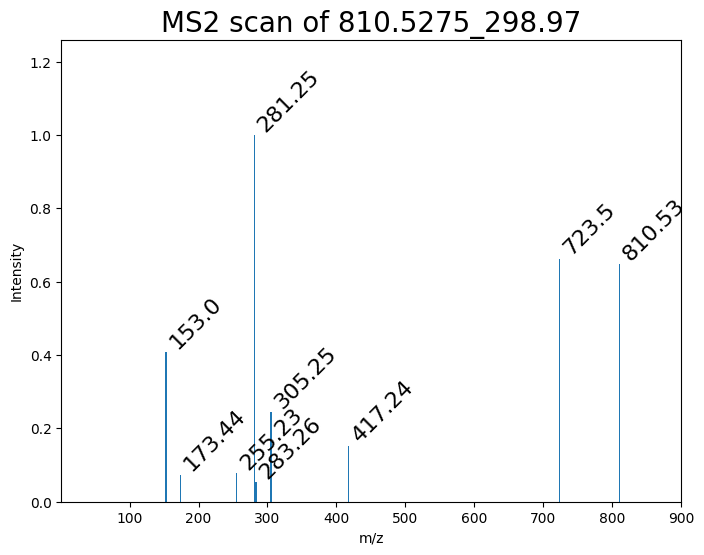

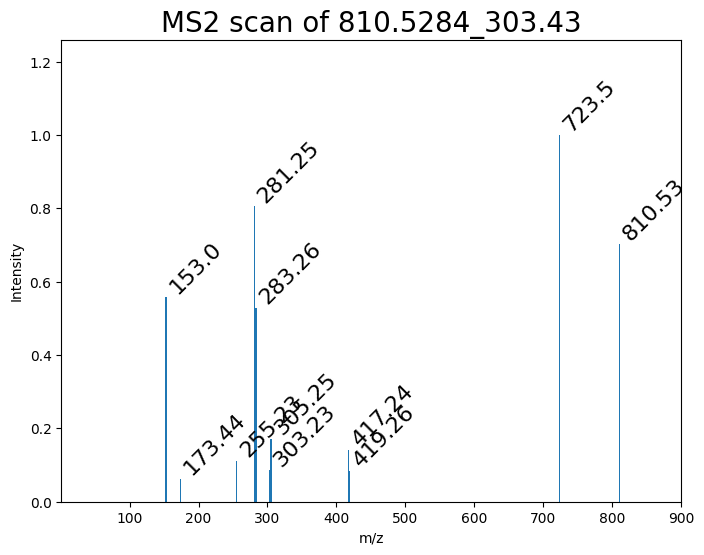

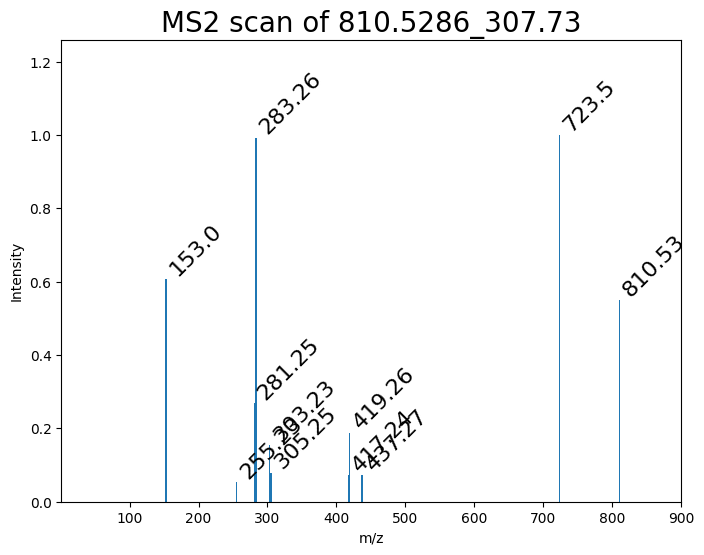

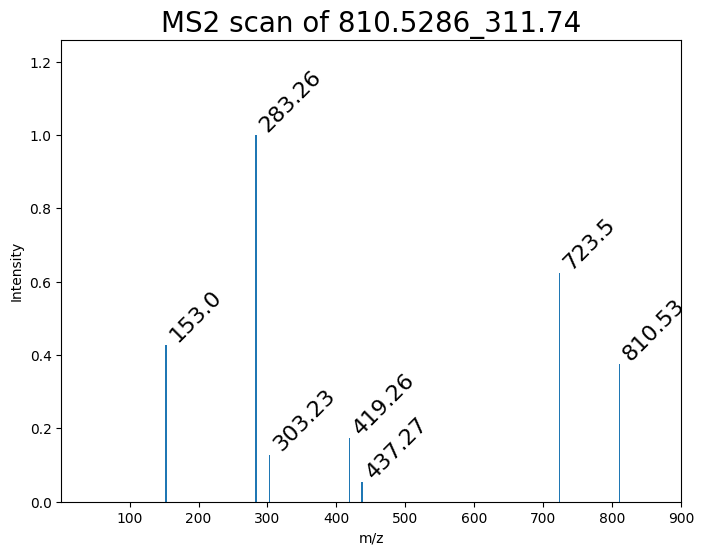

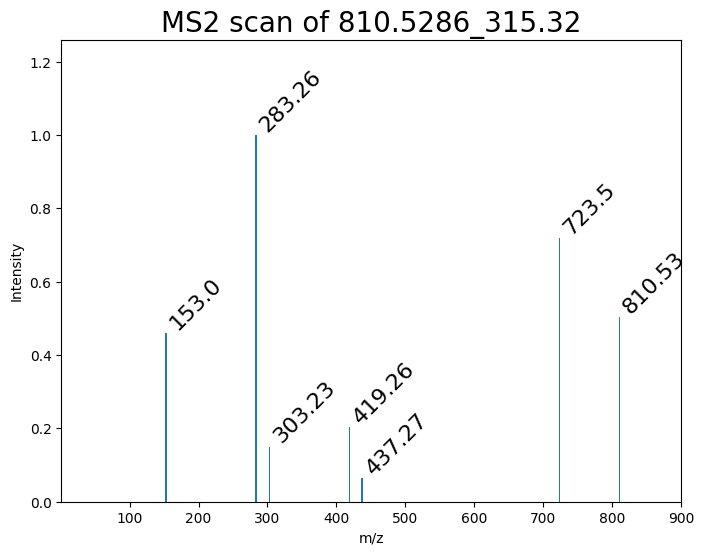

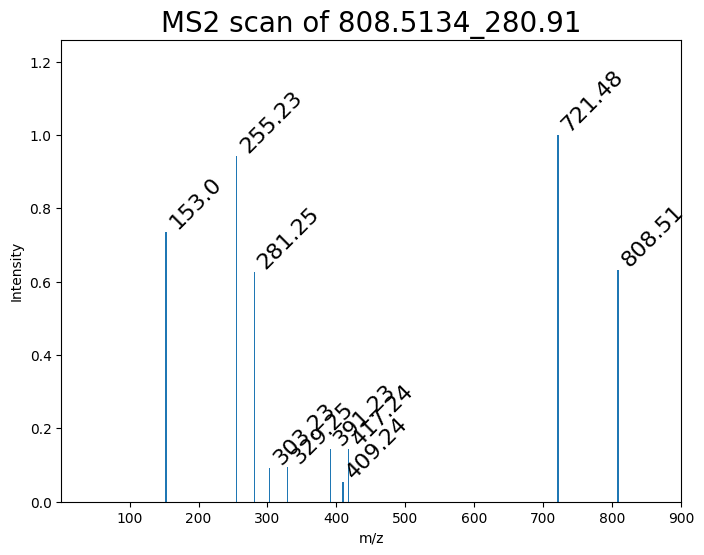

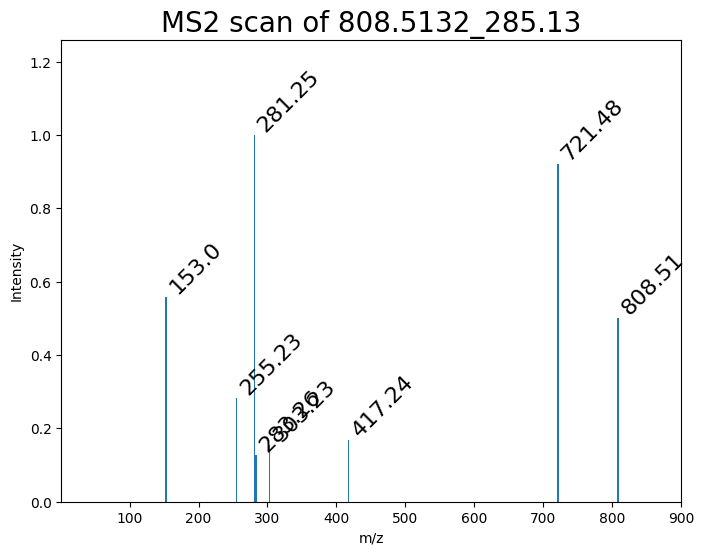

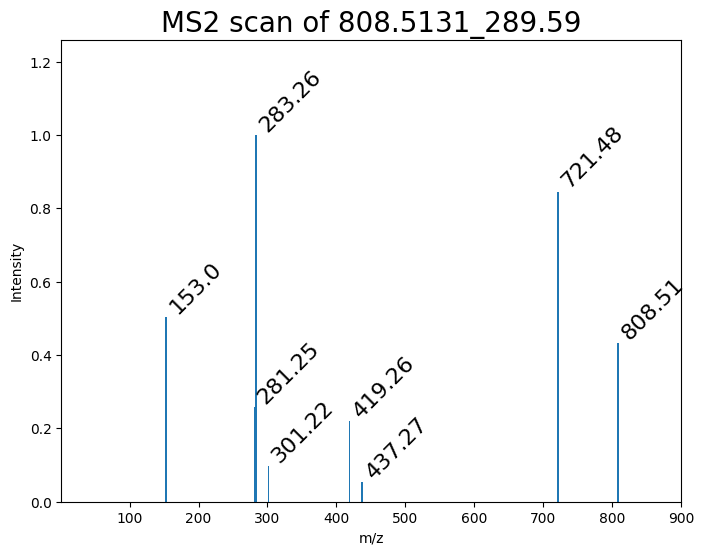

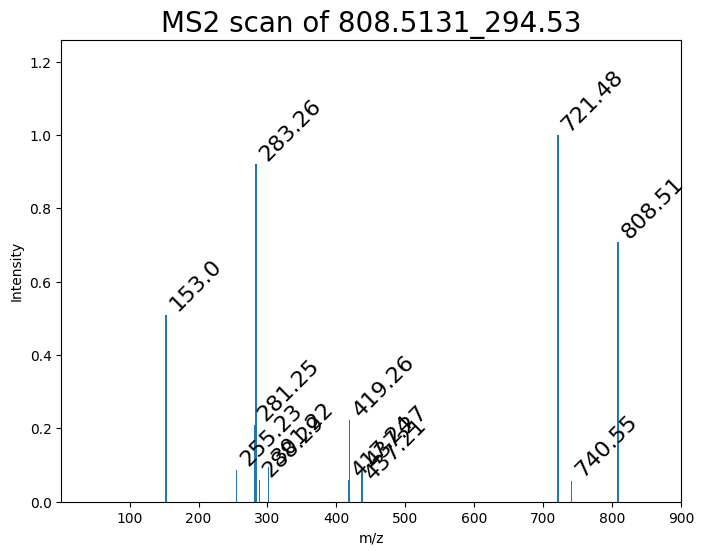

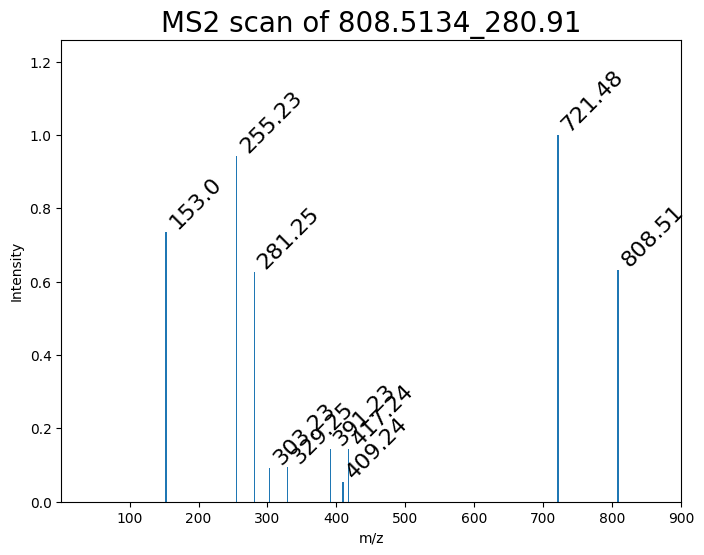

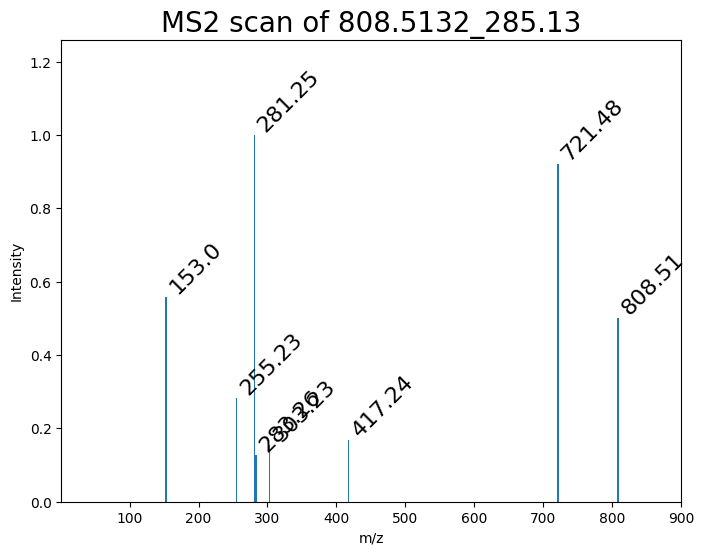

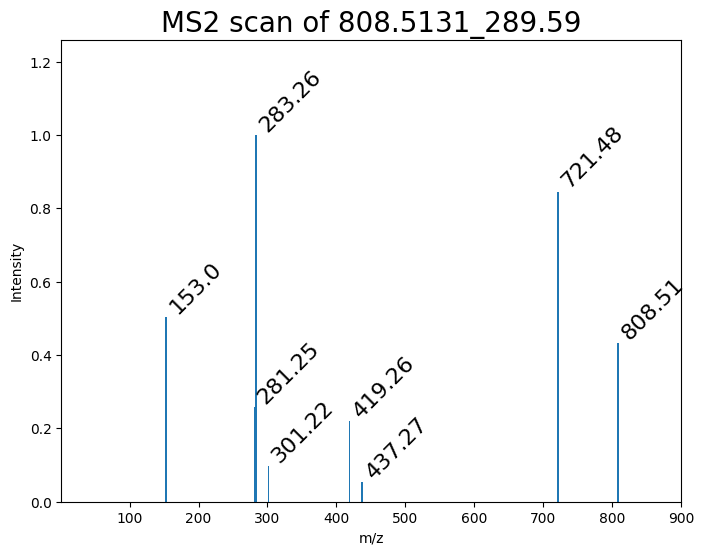

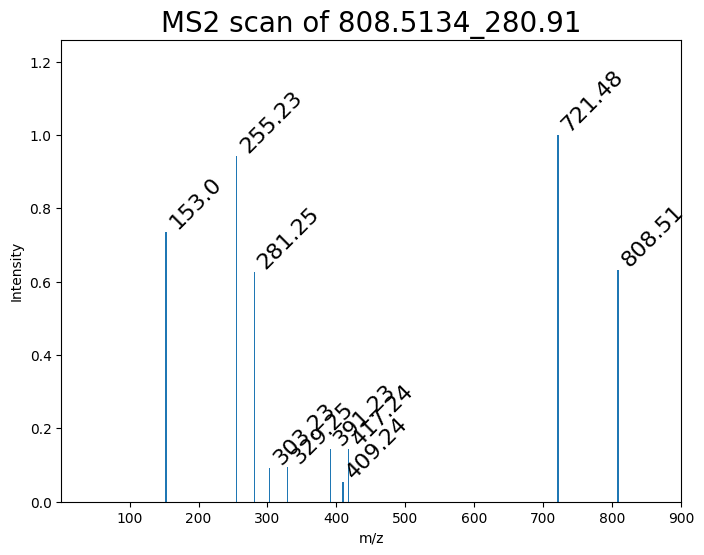

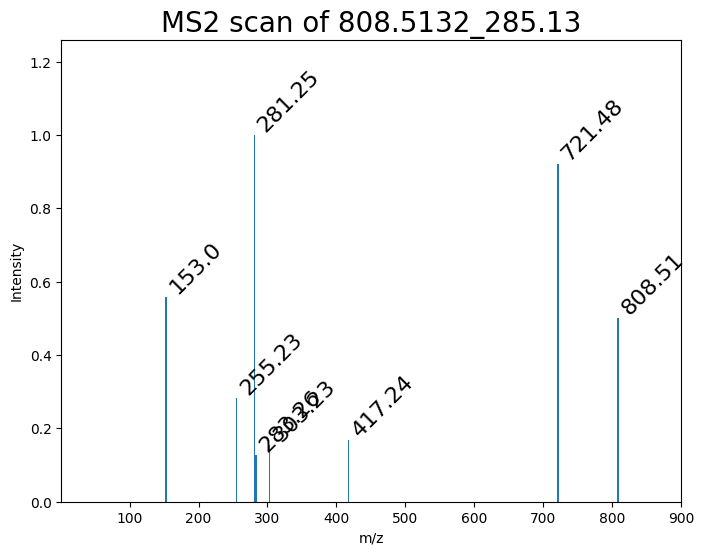

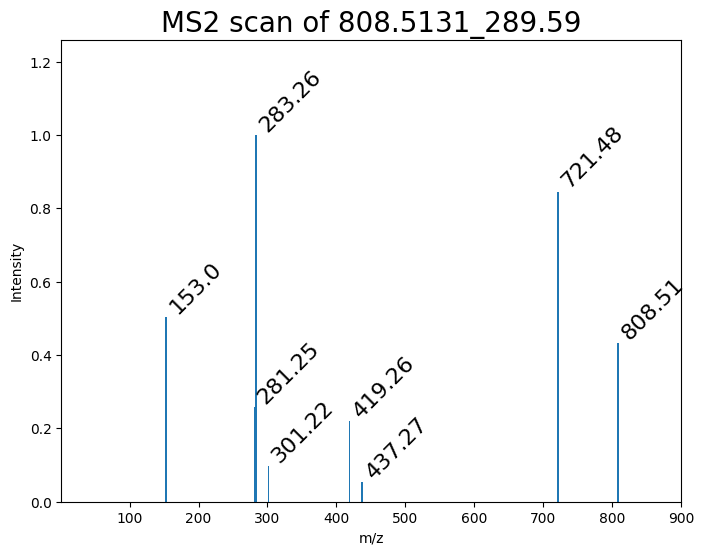

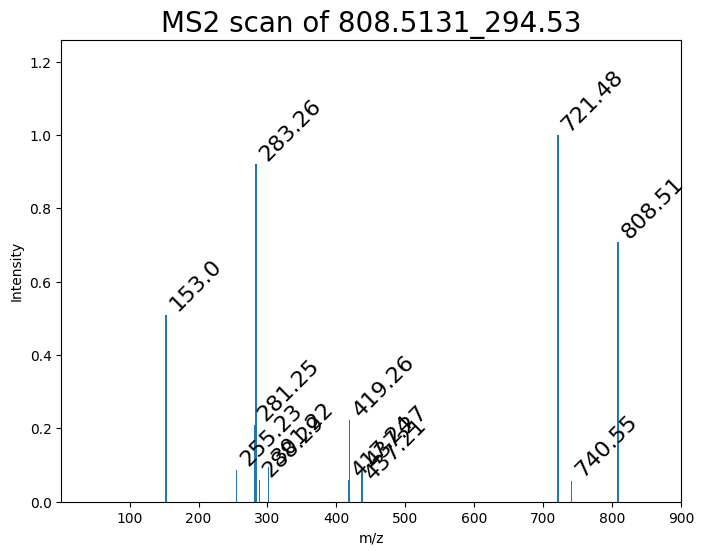

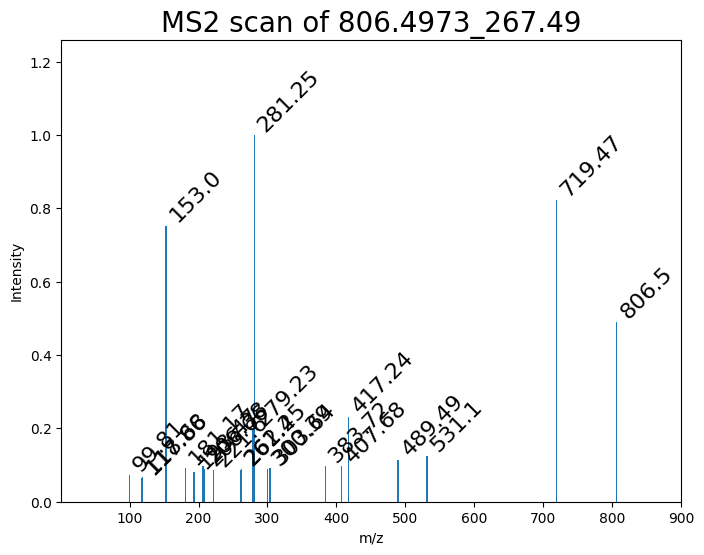

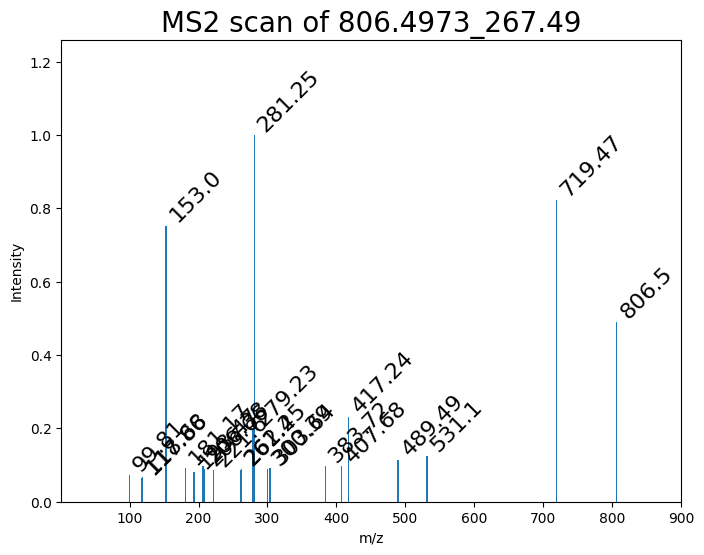

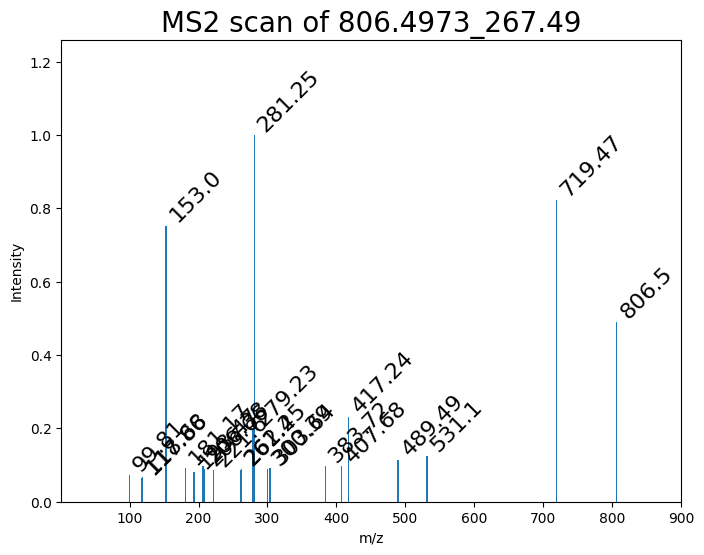

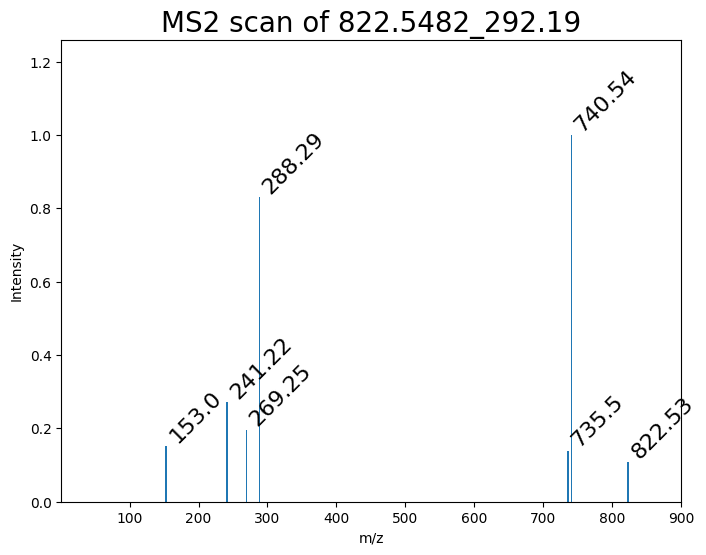

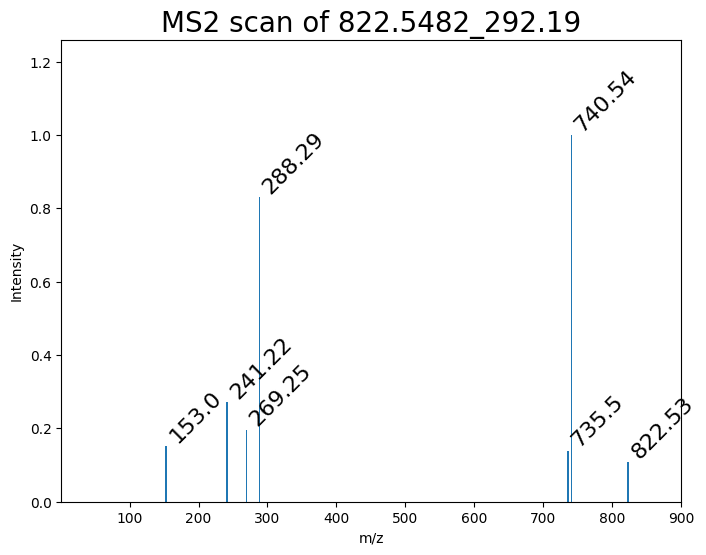

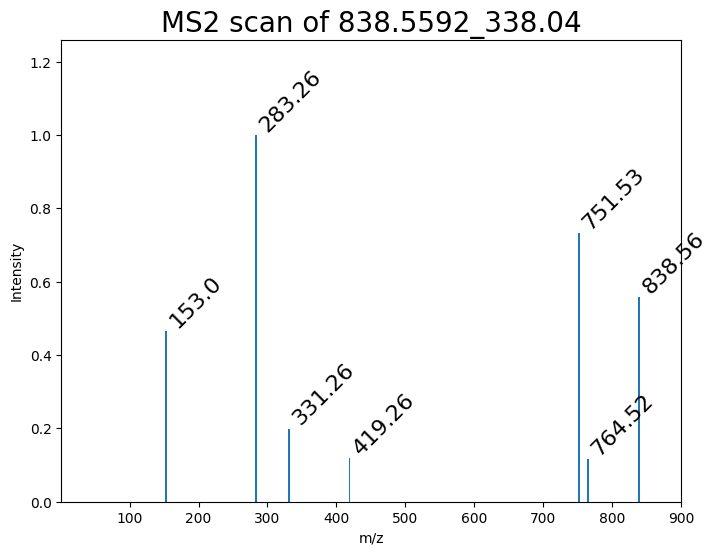

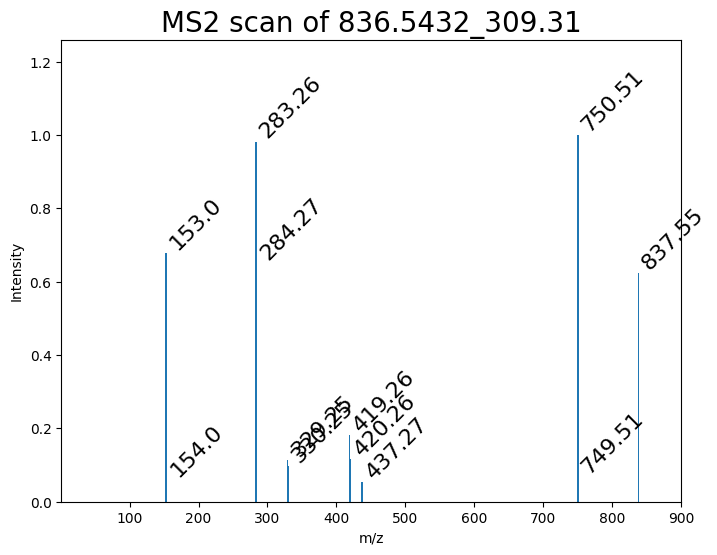

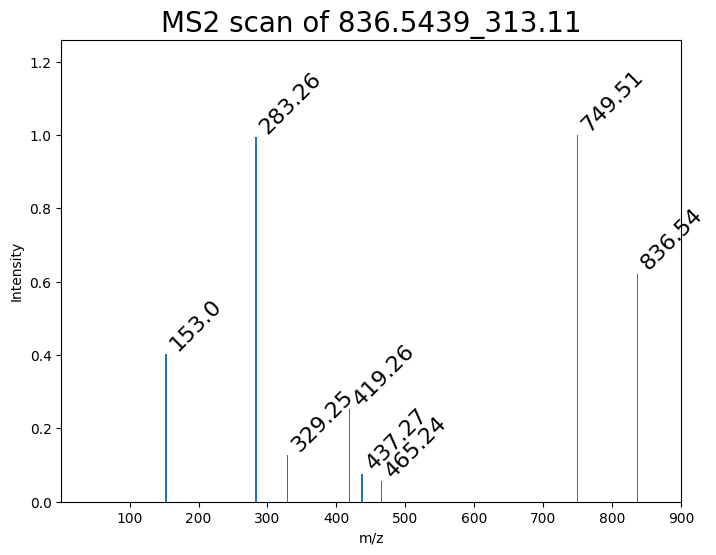

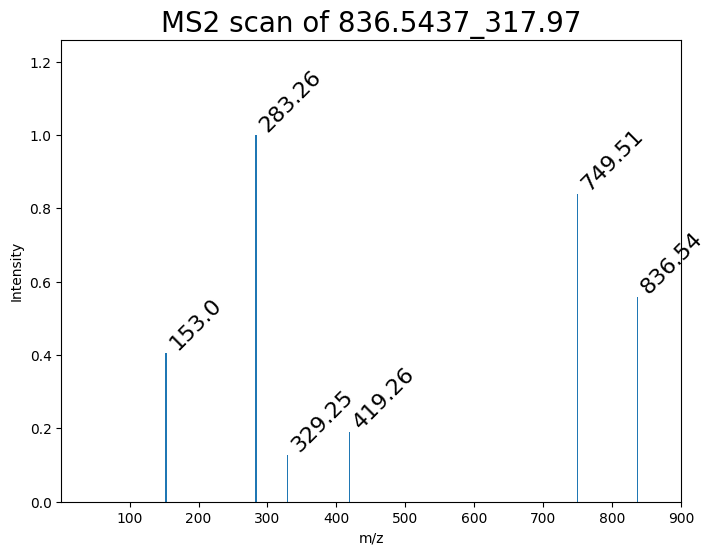

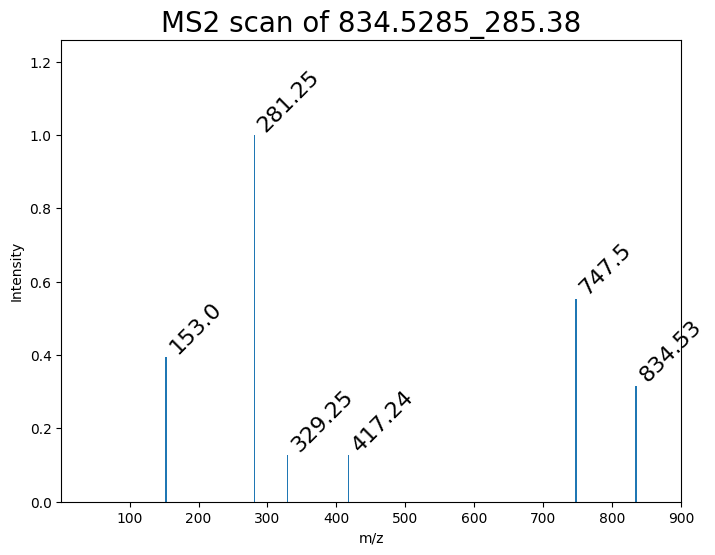

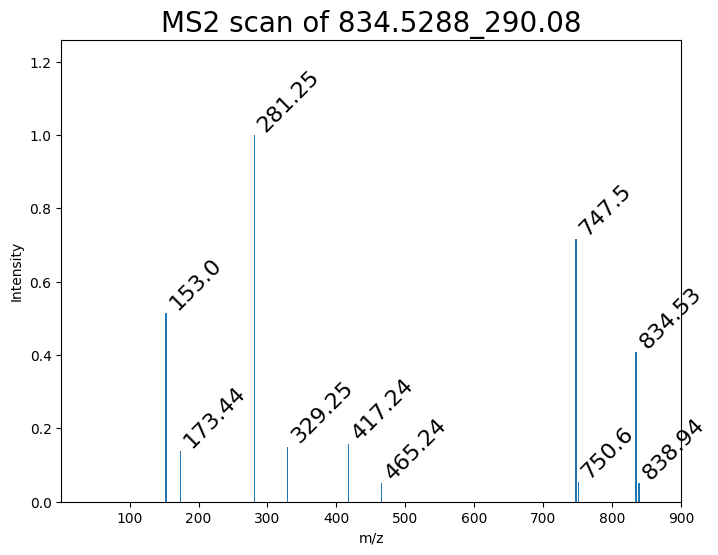

In [39]:
for FTID in parsed_NL_res_dict_clean.keys():
    plot_spectrum_from_list_of_dict(spec_dicts = parsed_NL_res_dict_clean[FTID], 
                 save_figure=True,
                 output_path=f"./data/{output_fdr}/{FTID}_{annot_dict[FTID]['name']}/",
                 label = f"{FTID}_{annot_dict[FTID]['name']}"
                 )